In [125]:
# IMPORT LIBRARIES AND MODELS
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest


In [126]:
# INTRODUCTION
# This notebook will cover the evaluation and optimisation of a machine learning model designed to predict the
# outcomes of EPL matches. We will first conduct data transformation and visualisation, and will then split the dataset
# chronologically into training, validation and test sets, and evaluate and optimise performance over three different models
# and a variety of hyperparameters. Finally, we will present our chosen model, a Support Vector classifier, that displays a
# relatively high level of accuracy (greater than 50%) over all three of the split datasets, and predicts mostly wins for ten
 #EPL matches that are to take place in early January 2023.

In [127]:
# DATA IMPORT
#MODIFY STRING INSIDE BRACKETS BASED OFF TRANING DATA LOCATION
data = pd.read_csv("epl-training.csv")

In [128]:
#DATA TRANSFORMATION

# REMOVE NAN DATA,ONE ROW IN THE TRAINING DATA HAS ONLY NANS
nan_data =data[data.isna().any(axis=1)]
data = data.dropna()
data = data.reset_index(drop='True')

for i in range (data.shape[0]): # Make all dates the same format
    if len(data.iloc[i,0]) == 8:
        data.iloc[i,0] = data.iloc[i,0][0:6] + "20" + data.iloc[i,0][6:8]

data["Date"] = pd.to_datetime(data["Date"],infer_datetime_format=True) # Convert date to datetime

data = data.drop(columns = ['Referee']) # DROP REFEREE COLUMN

print(data)


           Date    HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR    HS    AS   HST  AST    HC    AC    HF    AF   HY   AY   HR   AR
0    2000-08-19    Charlton       Man City   4.0   0.0   H   2.0   0.0   H  17.0   8.0  14.0  4.0   6.0   6.0  13.0  12.0  1.0  2.0  0.0  0.0
1    2000-08-19     Chelsea       West Ham   4.0   2.0   H   1.0   0.0   H  17.0  12.0  10.0  5.0   7.0   7.0  19.0  14.0  1.0  2.0  0.0  0.0
2    2000-08-19    Coventry  Middlesbrough   1.0   3.0   A   1.0   1.0   D   6.0  16.0   3.0  9.0   8.0   4.0  15.0  21.0  5.0  3.0  1.0  0.0
3    2000-08-19       Derby    Southampton   2.0   2.0   D   1.0   2.0   A   6.0  13.0   4.0  6.0   5.0   8.0  11.0  13.0  1.0  1.0  0.0  0.0
4    2000-08-19       Leeds        Everton   2.0   0.0   H   2.0   0.0   H  17.0  12.0   8.0  6.0   6.0   4.0  21.0  20.0  1.0  3.0  0.0  0.0
...         ...         ...            ...   ...   ...  ..   ...   ...  ..   ...   ...   ...  ...   ...   ...   ...   ...  ...  ...  ...  ...
8481 2

In [129]:
# Lists of all the home and away teams.

UniqueHomeTeams = data["HomeTeam"].unique()

UniqueAwayTeams = data["AwayTeam"].unique()

Features = data[['FTR']].copy()
Features["FTR"] = Features["FTR"].astype("category").cat.codes # Home win = 2, Draw = 1, Away win = 0 

Features["Year"] = data["Date"].dt.year
Features["Month"] = data["Date"].dt.month
Features["Day"] = data["Date"].dt.day

# CONVERT CATEGORIAL HOME AND AWAY TEAM FEATURES INTO MULTIPLE BINARY FEATURES

for i in range(0,UniqueHomeTeams.shape[0]):
    Team = UniqueHomeTeams[i]
    Features[Team+"Home"] = 0
    for j in range(0, data.shape[0]): # From a to b-1
        if data.iloc[j, data.columns.get_loc("HomeTeam")] == Team:
            Features.iloc[j, Features.columns.get_loc(Team+"Home")] = 1 

for i in range(0,UniqueAwayTeams.shape[0]):
    Team = UniqueAwayTeams[i]
    Features[Team+"Away"] = 0
    for j in range(0, data.shape[0]): # From a to b-1
        if data.iloc[j, data.columns.get_loc("AwayTeam")] == Team:
            Features.iloc[j, Features.columns.get_loc(Team+"Away")] = 1 
            


In [130]:
print(UniqueHomeTeams.shape[0])
print(UniqueAwayTeams.shape[0])

45
45


In [131]:
print(Features.iloc[0:5,0:9])

   FTR  Year  Month  Day  CharltonHome  ChelseaHome  CoventryHome  DerbyHome  LeedsHome
0    2  2000      8   19             1            0             0          0          0
1    2  2000      8   19             0            1             0          0          0
2    0  2000      8   19             0            0             1          0          0
3    1  2000      8   19             0            0             0          1          0
4    2  2000      8   19             0            0             0          0          1


In [132]:
AllTeams = []

for i in range(0,UniqueHomeTeams.shape[0]):
    AllTeams.append(UniqueHomeTeams[i])

for i in range(0,UniqueAwayTeams.shape[0]):
    AllTeams.append(UniqueAwayTeams[i])

AllTeams = set(AllTeams)

# COMBINE UNIQUE HOME AND AWAY TEAM  LISTS INTO ONE SET TO CREATE DATAFRAME WITH ONE ROW FOR EACH TEAM IN DATASET

Teams = pd.DataFrame(AllTeams)

Teams.columns = ['Team']

Teams['Stadium Latitude'] = 0
Teams['Stadium Longitude'] = 0

# FIND LATITUDE AND LONGITUDE OF EVERY TEAM'S HOME GROUNDS
# SOME TEAMS HAVE MOVED GROUNDS IN THE 20 YEAR PERIOD COVERED
# BY THE DATA BUT THE DISTANCE BETWEEN OLD GROUNDS AND NEW GROUNDS
# IS NEGLIGIBLE

Teams.iloc[Teams.loc[Teams.Team == 'Reading'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.42
Teams.iloc[Teams.loc[Teams.Team == 'Reading'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.98

Teams.iloc[Teams.loc[Teams.Team == 'Tottenham'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.60
Teams.iloc[Teams.loc[Teams.Team == 'Tottenham'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.07

Teams.iloc[Teams.loc[Teams.Team == 'Chelsea'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.48
Teams.iloc[Teams.loc[Teams.Team == 'Chelsea'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.19

Teams.iloc[Teams.loc[Teams.Team == 'Newcastle'].index, Teams.columns.get_loc("Stadium Latitude")] = 54.98
Teams.iloc[Teams.loc[Teams.Team == 'Newcastle'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.62

Teams.iloc[Teams.loc[Teams.Team == 'Nott\'m Forest'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.94
Teams.iloc[Teams.loc[Teams.Team == 'Nott\'m Forest'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.13

Teams.iloc[Teams.loc[Teams.Team == 'Nott\'m Forest'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.94
Teams.iloc[Teams.loc[Teams.Team == 'Nott\'m Forest'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.13

Teams.iloc[Teams.loc[Teams.Team == 'Bradford'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.80
Teams.iloc[Teams.loc[Teams.Team == 'Bradford'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.76

Teams.iloc[Teams.loc[Teams.Team == 'Brighton'].index, Teams.columns.get_loc("Stadium Latitude")] = 50.86
Teams.iloc[Teams.loc[Teams.Team == 'Brighton'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.08

Teams.iloc[Teams.loc[Teams.Team == 'Huddersfield'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.65
Teams.iloc[Teams.loc[Teams.Team == 'Huddersfield'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.77

Teams.iloc[Teams.loc[Teams.Team == 'Burnley'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.79
Teams.iloc[Teams.loc[Teams.Team == 'Burnley'].index, Teams.columns.get_loc("Stadium Longitude")] = -2.23

Teams.iloc[Teams.loc[Teams.Team == 'Blackpool'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.80
Teams.iloc[Teams.loc[Teams.Team == 'Blackpool'].index, Teams.columns.get_loc("Stadium Longitude")] = -3.04

Teams.iloc[Teams.loc[Teams.Team == 'Birmingham'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.48
Teams.iloc[Teams.loc[Teams.Team == 'Birmingham'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.87

Teams.iloc[Teams.loc[Teams.Team == 'Fulham'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.48
Teams.iloc[Teams.loc[Teams.Team == 'Fulham'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.22

Teams.iloc[Teams.loc[Teams.Team == 'Man United'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.46
Teams.iloc[Teams.loc[Teams.Team == 'Man United'].index, Teams.columns.get_loc("Stadium Longitude")] = -2.29

Teams.iloc[Teams.loc[Teams.Team == 'West Brom'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.51
Teams.iloc[Teams.loc[Teams.Team == 'West Brom'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.96

Teams.iloc[Teams.loc[Teams.Team == 'Derby'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.92
Teams.iloc[Teams.loc[Teams.Team == 'Derby'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.45

Teams.iloc[Teams.loc[Teams.Team == 'Charlton'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.49
Teams.iloc[Teams.loc[Teams.Team == 'Charlton'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.04

Teams.iloc[Teams.loc[Teams.Team == 'Brentford'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.49
Teams.iloc[Teams.loc[Teams.Team == 'Brentford'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.30

Teams.iloc[Teams.loc[Teams.Team == 'Portsmouth'].index, Teams.columns.get_loc("Stadium Latitude")] = 50.80
Teams.iloc[Teams.loc[Teams.Team == 'Portsmouth'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.06

Teams.iloc[Teams.loc[Teams.Team == 'Coventry'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.45
Teams.iloc[Teams.loc[Teams.Team == 'Coventry'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.50

Teams.iloc[Teams.loc[Teams.Team == 'Stoke'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.99
Teams.iloc[Teams.loc[Teams.Team == 'Stoke'].index, Teams.columns.get_loc("Stadium Longitude")] = -2.18

Teams.iloc[Teams.loc[Teams.Team == 'Man City'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.48
Teams.iloc[Teams.loc[Teams.Team == 'Man City'].index, Teams.columns.get_loc("Stadium Longitude")] = -2.20

Teams.iloc[Teams.loc[Teams.Team == 'Wolves'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.59
Teams.iloc[Teams.loc[Teams.Team == 'Wolves'].index, Teams.columns.get_loc("Stadium Longitude")] = -2.13

Teams.iloc[Teams.loc[Teams.Team == 'West Ham'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.54
Teams.iloc[Teams.loc[Teams.Team == 'West Ham'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.02

Teams.iloc[Teams.loc[Teams.Team == 'Everton'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.44
Teams.iloc[Teams.loc[Teams.Team == 'Everton'].index, Teams.columns.get_loc("Stadium Longitude")] = -2.97

Teams.iloc[Teams.loc[Teams.Team == 'Crystal Palace'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.40
Teams.iloc[Teams.loc[Teams.Team == 'Crystal Palace'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.09

Teams.iloc[Teams.loc[Teams.Team == 'Bournemouth'].index, Teams.columns.get_loc("Stadium Latitude")] = 50.74
Teams.iloc[Teams.loc[Teams.Team == 'Bournemouth'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.84

Teams.iloc[Teams.loc[Teams.Team == 'Cardiff'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.47
Teams.iloc[Teams.loc[Teams.Team == 'Cardiff'].index, Teams.columns.get_loc("Stadium Longitude")] = -3.20

Teams.iloc[Teams.loc[Teams.Team == 'Ipswich'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.06
Teams.iloc[Teams.loc[Teams.Team == 'Ipswich'].index, Teams.columns.get_loc("Stadium Longitude")] = 1.14

Teams.iloc[Teams.loc[Teams.Team == 'Blackburn'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.73
Teams.iloc[Teams.loc[Teams.Team == 'Blackburn'].index, Teams.columns.get_loc("Stadium Longitude")] = -2.49

Teams.iloc[Teams.loc[Teams.Team == 'Middlesbrough'].index, Teams.columns.get_loc("Stadium Latitude")] = 54.58
Teams.iloc[Teams.loc[Teams.Team == 'Middlesbrough'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.22

Teams.iloc[Teams.loc[Teams.Team == 'Bolton'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.58
Teams.iloc[Teams.loc[Teams.Team == 'Bolton'].index, Teams.columns.get_loc("Stadium Longitude")] = -2.54

Teams.iloc[Teams.loc[Teams.Team == 'Southampton'].index, Teams.columns.get_loc("Stadium Latitude")] = 50.91
Teams.iloc[Teams.loc[Teams.Team == 'Southampton'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.39

Teams.iloc[Teams.loc[Teams.Team == 'Wigan'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.55
Teams.iloc[Teams.loc[Teams.Team == 'Wigan'].index, Teams.columns.get_loc("Stadium Longitude")] = -2.65

Teams.iloc[Teams.loc[Teams.Team == 'Watford'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.65
Teams.iloc[Teams.loc[Teams.Team == 'Watford'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.40

Teams.iloc[Teams.loc[Teams.Team == 'QPR'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.51
Teams.iloc[Teams.loc[Teams.Team == 'QPR'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.23

Teams.iloc[Teams.loc[Teams.Team == 'Swansea'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.64
Teams.iloc[Teams.loc[Teams.Team == 'Swansea'].index, Teams.columns.get_loc("Stadium Longitude")] = -3.94

Teams.iloc[Teams.loc[Teams.Team == 'Aston Villa'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.51
Teams.iloc[Teams.loc[Teams.Team == 'Aston Villa'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.88

Teams.iloc[Teams.loc[Teams.Team == 'Sheffield United'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.37
Teams.iloc[Teams.loc[Teams.Team == 'Sheffield United'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.47

Teams.iloc[Teams.loc[Teams.Team == 'Leeds'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.78
Teams.iloc[Teams.loc[Teams.Team == 'Leeds'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.57

Teams.iloc[Teams.loc[Teams.Team == 'Sunderland'].index, Teams.columns.get_loc("Stadium Latitude")] = 54.91
Teams.iloc[Teams.loc[Teams.Team == 'Sunderland'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.39

Teams.iloc[Teams.loc[Teams.Team == 'Norwich'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.62
Teams.iloc[Teams.loc[Teams.Team == 'Norwich'].index, Teams.columns.get_loc("Stadium Longitude")] = 1.31

Teams.iloc[Teams.loc[Teams.Team == 'Hull'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.75
Teams.iloc[Teams.loc[Teams.Team == 'Hull'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.37

Teams.iloc[Teams.loc[Teams.Team == 'Liverpool'].index, Teams.columns.get_loc("Stadium Latitude")] = 53.43
Teams.iloc[Teams.loc[Teams.Team == 'Liverpool'].index, Teams.columns.get_loc("Stadium Longitude")] = -2.96

Teams.iloc[Teams.loc[Teams.Team == 'Arsenal'].index, Teams.columns.get_loc("Stadium Latitude")] = 51.56
Teams.iloc[Teams.loc[Teams.Team == 'Arsenal'].index, Teams.columns.get_loc("Stadium Longitude")] = -0.11

Teams.iloc[Teams.loc[Teams.Team == 'Leicester'].index, Teams.columns.get_loc("Stadium Latitude")] = 52.62
Teams.iloc[Teams.loc[Teams.Team == 'Leicester'].index, Teams.columns.get_loc("Stadium Longitude")] = -1.14

Teams

,Team,Stadium Latitude,Stadium Longitude
0,West Ham,51.54,-0.02
1,Newcastle,54.98,-1.62
2,Sunderland,54.91,-1.39
3,Cardiff,51.47,-3.20
4,Brighton,50.86,-0.08
5,Fulham,51.48,-0.22
6,Derby,52.92,-1.45
7,Reading,51.42,-0.98
8,Wolves,52.59,-2.13
9,Man City,53.48,-2.20


In [133]:
print(len(set(AllTeams)))

45


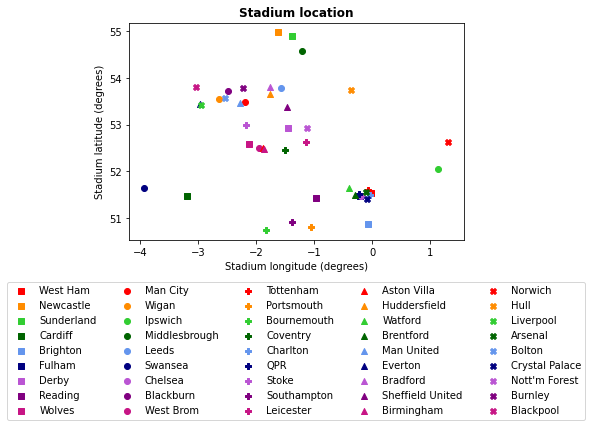

In [134]:
# VISUALISE STADIUM LOCATIONS IN GRAPH SHOWING LATITUDE AND LONGITUDE

TeamsColumn = Teams['Team']
LongitudeColumn = Teams['Stadium Longitude']
LatitudeColumn = Teams['Stadium Latitude']
Colours = []
Shapes = []
markers = [ "s" , "o" , "P" , "^" , "X"]
colours = ['red','darkorange','limegreen','darkgreen','cornflowerblue','navy','mediumorchid','purple','mediumvioletred',]

for i in range(0, 5, 1):
    for j in range(0, 9, 1):
        Shapes.append(markers[i])
        Colours.append(colours[j])

Colour ='white'

fig, ax = plt.subplots(facecolor=Colour)

for i in range (Teams.shape[0]):
    ax.scatter(LongitudeColumn[i], LatitudeColumn[i], c=Colours[i], marker=Shapes[i])

ax.legend(TeamsColumn,loc='lower center', bbox_to_anchor=(0.5, -0.85),
          ncol=5, fancybox=True,facecolor=Colour)

ax.set_xlabel('Stadium longitude (degrees)')
ax.set_ylabel('Stadium latitude (degrees)')

ax.set_title('Stadium location', fontsize = 12, fontweight ='bold')

ax.set_facecolor(Colour)

plt.show()



In [135]:
# CALCULATE THE DISTANCE THE AWAY TEAM HAS TO TRAVEL FOR EACH MATCH

Features["AT-DT-Km"] = 0 # AWAY TEAM DISTANCE TRAVELLED KILOMETRES
Earthradius = 6371000
for i in range (data.shape[0]):
    HomeTeam = data.iloc[i, data.columns.get_loc("HomeTeam")]
    AwayTeam = data.iloc[i, data.columns.get_loc("AwayTeam")]
    HomeLatitude = Teams.iloc[Teams.loc[Teams['Team'] == HomeTeam].index[0], Teams.columns.get_loc("Stadium Latitude")] * math.pi / 180
    HomeLongitude = Teams.iloc[Teams.loc[Teams['Team'] == HomeTeam].index[0], Teams.columns.get_loc("Stadium Longitude")] * math.pi / 180
    AwayLatitude = Teams.iloc[Teams.loc[Teams['Team'] == AwayTeam].index[0], Teams.columns.get_loc("Stadium Latitude")] * math.pi / 180
    AwayLongitude = Teams.iloc[Teams.loc[Teams['Team'] == AwayTeam].index[0], Teams.columns.get_loc("Stadium Longitude")] * math.pi / 180
    DistanceTravelled = Earthradius * math.acos( math.sin(HomeLatitude)*math.sin(AwayLatitude) + math.cos(HomeLatitude)*math.cos(AwayLatitude)*math.cos(HomeLongitude-AwayLongitude) ) / 1000
    Features.iloc[i, Features.columns.get_loc("AT-DT-Km")] = DistanceTravelled

# CALCULATE DISTANCE USING LAW OF SPHERICAL COSINES https://www.movable-type.co.uk/scripts/latlong.html


In [136]:
print(Features.iloc[-5:,-2:])

      Nott'm ForestAway    AT-DT-Km
8481                  0  275.182567
8482                  0  286.686472
8483                  0   99.622511
8484                  1  168.423894
8485                  0  263.012301


In [137]:
# ADD EMPTY COLUMNS FOR MORE FEATURES IN THE FEATURES DATAFRAME

Features = pd.concat([Features, pd.DataFrame(0, index=Features.index, columns=["FTHG","FTAG",'HTHG','HTAG','HS','AS','HST','AST','HC','AC','HF','AF','HY','AY','HR','AR','HFTR','HHTR','AFTR','AHTR'])], axis=1)

# "HFTR" = HOME FULL TIME RESULT
# "HHTR" = HOME HALF TIME RESULT
# "AFTR" = AWAY FULL TIME RESULT
# "AHTR" = AWAY HALF TIME RESULT

In [138]:
data['FTR'].replace(['H', 'D', 'A'], [1, 0, -1], inplace=True)
data['HTR'].replace(['H', 'D', 'A'], [1, 0, -1], inplace=True)

# EVERY MATCH IN THE FEATURES DATAFRAME WILL END UP WITH FEATURES CONTAINING THE HOME TEAM'S HOME MATCH STATS PRIOR TO THAT GAME AND THE AWAY TEAM'S AWAY MATCH STATS PRIOR TO THAT GAME

# TO DO THIS, TWO LISTS, A HOME LIST AND AWAY LIST, ARE CREATED THAT CONTAINS A DATAFRAME FOR EVERY TEAM
# THEN ITERATE THROUGH THE MATCHES
# AT EACH MATCH, FIND MEAN VALUES FROM THE TEAM'S PREVIOUS MATCHES AND ADD THEM TO THE FEATURES DATAFRAME
# THEN ADD THAT MATCH'S STATS TO THE TEAM DATAFRAME IN THE HOME LIST AND AWAY LIST

Homelist = []

for i in range (Teams.shape[0]):
    Homelist.append(data[0:0])

# Create list of dataframes
# One dataframe per team
# Team holds team performances prior to a match

Awaylist = []

for i in range (Teams.shape[0]):
    Awaylist.append(data[0:0])

for i in range (data.shape[0]):
    HomeTeam = data.iloc[i, data.columns.get_loc("HomeTeam")] # Take team names
    AwayTeam = data.iloc[i, data.columns.get_loc("AwayTeam")]
    Homelistindex = Teams.loc[Teams['Team'] == HomeTeam].index[0] # Add home team's previous mean performance to the current football match in the data set
    Features.iloc[i, Features.columns.get_loc("FTHG")] = Homelist[Homelistindex]['FTHG'].mean()
    Features.iloc[i, Features.columns.get_loc("HTHG")] = Homelist[Homelistindex]['HTHG'].mean()
    Features.iloc[i, Features.columns.get_loc("HS")] = Homelist[Homelistindex]['HS'].mean()
    Features.iloc[i, Features.columns.get_loc("HST")] = Homelist[Homelistindex]['HST'].mean()
    Features.iloc[i, Features.columns.get_loc("HC")] = Homelist[Homelistindex]['HC'].mean()
    Features.iloc[i, Features.columns.get_loc("HF")] = Homelist[Homelistindex]['HF'].mean()
    Features.iloc[i, Features.columns.get_loc("HY")] = Homelist[Homelistindex]['HY'].mean()
    Features.iloc[i, Features.columns.get_loc("HR")] = Homelist[Homelistindex]['HR'].mean()
    Features.iloc[i, Features.columns.get_loc("HFTR")] = Homelist[Homelistindex]['FTR'].mean()
    Features.iloc[i, Features.columns.get_loc("HHTR")] = Homelist[Homelistindex]['HTR'].mean()
    Homelist[Homelistindex] = pd.concat([Homelist[Homelistindex], data.iloc[[i]]],ignore_index=True)
    # Add the football matches stats to the home team's dataframe inside the Homelist 

    Awaylistindex = Teams.loc[Teams['Team'] == AwayTeam].index[0]
    Features.iloc[i, Features.columns.get_loc("FTAG")] = Awaylist[Awaylistindex]['FTAG'].mean()
    Features.iloc[i, Features.columns.get_loc("HTAG")] = Awaylist[Awaylistindex]['HTAG'].mean()
    Features.iloc[i, Features.columns.get_loc("AS")] = Awaylist[Awaylistindex]['AS'].mean()
    Features.iloc[i, Features.columns.get_loc("AST")] = Awaylist[Awaylistindex]['AST'].mean()
    Features.iloc[i, Features.columns.get_loc("AC")] = Awaylist[Awaylistindex]['AC'].mean()
    Features.iloc[i, Features.columns.get_loc("AF")] = Awaylist[Awaylistindex]['AF'].mean()
    Features.iloc[i, Features.columns.get_loc("AY")] = Awaylist[Awaylistindex]['AY'].mean()
    Features.iloc[i, Features.columns.get_loc("AR")] = Awaylist[Awaylistindex]['AR'].mean()
    Features.iloc[i, Features.columns.get_loc("AFTR")] = -Awaylist[Awaylistindex]['FTR'].mean() # NEGATIVE MEAN BECAUSE AN AWAY WIN IS REPRESENTED BY -1
    Features.iloc[i, Features.columns.get_loc("AHTR")] = -Awaylist[Awaylistindex]['HTR'].mean() # BUT A HIGH AWAY WIN RATE SHOULD BE POSITIVE
    Awaylist[Awaylistindex] = pd.concat([Awaylist[Awaylistindex], data.iloc[[i]]],ignore_index=True)


In [139]:
print(Homelist[1].iloc[-5:,0:9]) # FOR EXAMPLE INDEX 1 CONTAINS ALL OF THE MATCHES PLAYED AT HOME BY A SINGLE TEAM 

          Date   HomeTeam        AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR
382 2022-09-03  Newcastle  Crystal Palace   0.0   0.0    0   0.0   0.0    0
383 2022-09-17  Newcastle     Bournemouth   1.0   1.0    0   0.0   0.0    0
384 2022-10-08  Newcastle       Brentford   5.0   1.0    1   2.0   0.0    1
385 2022-10-19  Newcastle         Everton   1.0   0.0    1   1.0   0.0    1
386 2022-10-29  Newcastle     Aston Villa   4.0   0.0    1   1.0   0.0    1


In [140]:

#print(Homelist)
#print(Awaylist)
print(Features.iloc[-5:,-5:])


            AR      HFTR      HHTR      AFTR      AHTR
8481  0.065395  0.158031  0.088083 -0.209809 -0.084469
8482  0.096698  0.068729  0.034364 -0.160377 -0.089623
8483  0.109244  0.525943  0.360849 -0.100840 -0.092437
8484  0.000000  0.555556  0.286052 -0.666667 -0.333333
8485  0.098093  0.557920  0.411348 -0.258856 -0.174387


In [141]:
# DIFFERENTIAL DATA EXPLORATION

def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

##importing data
set_pandas_display_options()
df = pd.read_csv("epl-training-with-seasons.csv")
extra_dataH = pd.read_csv("2017-2022.csv",index_col=None)
extra_dataH = extra_dataH.fillna(0)
col_names = extra_dataH.dtypes.keys().tolist()
col_names = col_names[2::]

differential_data= pd.DataFrame(columns=col_names)

##create new differential data set
for index1, row in df.iterrows():
    if int(row["Season"])>2017:
        season=int(row["Season"]) - 1
        HomeTeam = row["HomeTeam"]
        AwayTeam= row["AwayTeam"]
        for index2, row2 in extra_dataH.iterrows():
            if AwayTeam == row2["HomeTeam"] and season==row2["Season"]:
                rownum1 = index2
            if HomeTeam == row2["HomeTeam"] and season==row2["Season"]:
                rownum2 = index2
        row_1 = extra_dataH.iloc[rownum1]
        row_1 = row_1[2::]
        row_2 = extra_dataH.iloc[rownum2]
        row_2 = row_2[2::]
        result = row_1.sub(row_2)
        differential_data.loc[index1] = result

differential_data

,SAG_GA,SAG_PKA,SAG_FK,SAG_CK,SAG_OG,SAG_PSxG,SAG_PSxG/SoT,SAG_PSxG+/-,SAG_/90,SAG_Cmp,SAG_Att,SAG_Cmp%,SAG_Att.1,SAG_Thr,SAG_Launch%,SAG_AvgLen,SAG_G+A-PK,SAG_Launch%.1,SAG_AvgLen.1,SAG_Opp,SAG_Stp,SAG_Stp%,SAG_#OPA,SAG_#OPA/90,SAG_AvgDist,SDA_Tkl,SDA_TklW,SDA_Def3rd,SDA_Mid3rd,SDA_Att3rd,SDA_Tkl.1,SDA_Att,SDA_Tkl%,SDA_Past,SDA_Blocks,SDA_Sh,SDA_Pass,SDA_Int,SDA_Tkl+Int,SDA_Clr,SDA_Err,SGSC_SCA,SGSC_SCA90,SGSC_PassLive,SGSC_PassDead,SGSC_Drib,SGSC_Sh,SGSC_Fld,SGSC_Def,SGSC_GCA,SGSC_GCA90,SGSC_PassLive.1,SGSC_PassDead.1,SGSC_Drib.1,SGSC_Sh.1,SGSC_Fld.1,SGSC_Def.1,SM_CrdY,SM_CrdR,SM_2CrdY,SM_Fls,SM_Fld,SM_Off,SM_Crs,SM_Int,SM_TklW,SM_PKwon,SM_PKcon,SM_OG,SM_Recov,SM_Won,SM_Lost,SM_Won%,PT_Att,PT_Live,PT_Dead,PT_FK,PT_TB,PT_Sw,PT_Crs,PT_TI,PT_CK,PT_In,PT_Out,PT_Str,PT_Cmp,PT_Off,PT_Blocks,P_Cmp,P_Att,P_Cmp%,P_TotDist,P_PrgDist,P_Cmp.1,P_Att.1,P_Cmp%.1,P_Cmp.2,P_Att.2,P_Cmp%.2,P_Cmp.3,P_Att.3,P_Cmp%.3,P_Ast,P_xAG,P_xA,P_A-xAG,P_KP,P_1/3,P_PPA,P_CrsPA,P_Prog,SPT_Age,SPT_MP,SPT_Mn/MP,SPT_Min%,SPT_90s,SPT_Start,SPT_Mn/Start,SPT_Compl,SPT_Subs,SPT_Mn/Sub,SPT_unSub,SPT_PPM,SPT_onG,SPT_onGA,SPT_+/-,SPT_+/-90,SPT_onxG,SPT_onxGA,SPT_xG+/-,SPT_xG+/-90,SP_Poss,SP_90s,SP_Touches,SP_DefPen,SP_Def3rd,SP_Mid3rd,SP_Att3rd,SP_AttPen,SP_Live,SP_Succ,SP_Att,SP_Succ%,SP_Mis,SP_Dis,SP_Rec,SP_Prog,SS_Gls,SS_Sh,SS_SoT,SS_SoT%,SS_Sh/90,SS_SoT/90,SS_G/Sh,SS_G/SoT,SS_Dist,SS_FK,SS_PK,SS_PKatt,SS_xG,SS_npxG,SS_npxG/Sh,SS_G-xG,SS_np:G-xG,SSS_Age,SSS_Poss,SSS_MP,SSS_Starts,SSS_90s,SSS_Gls,SSS_Ast,SSS_G-PK,SSS_PK,SSS_PKatt,SSS_CrdY,SSS_CrdR,SSS_Gls.1,SSS_Ast.1,SSS_G+A,SSS_G-PK.1,SSS_G+A-PK,SSS_xG,SSS_npxG,SSS_xAG,SSS_npxG+xAG,SSS_xG.1,SSS_xAG.1,SSS_xG+xAG,SSS_npxG.1,SSS_npxG+xAG.1,RS_xG,RS_xGA,RS_xGD,RS_xGD/90
6840,32,1,2,6,0,11.1,0.01,-20.9,-0.55,100,248,0.6,156,-18,11.9,3.9,10,15.7,7.5,62,11,1.6,45,1.19,3.7,66,48,57,31,-22,35,61,2.6,26,83,18,65,-67,-1,81,-3,-188,-4.95,-205,29,-8,0,0,-4,-23,-0.61,-13,2,-6,-7,2,-1,0.0,0.0,4,-41,-65,4,-9,-67,48,5,3,0,21,170,259,-4.5,-4741,-4883,138,-32,-22,-6,-9,145,-17,26,-37,-1,-5408,4,-28,-5408,-4741,-9.0,-66319,-12970,-2931,-2751,-6.8,-1844,-1594,-8.1,-31,299,-5.8,-15,-5.6,-11.1,-9.4,-80,-314,-132,-1,-285,0.5,0,0,0,0,0,0.0,0.0,-4,0,4,-0.89,-12,32,-44,-1.16,-5.7,7.4,-13.1,-0.35,-6.7,0,-4552,7,-473,-1915,-2113,-218,-4556,-44,-18,-4.5,4,-41,-5420,-281,-14,-92,-33,-0.5,-2.42,-0.86,-0.01,-0.04,-0.8,-10,4,3,-5.7,-8.0,0.0,-8.3,-10.0,0.5,-6.7,0,0,0,-14,-15,-18,4,3,0.0,0.0,-0.37,-0.39,-0.77,-0.48,-0.87,-5.7,-8.0,-5.6,-13.6,-0.15,-0.15,-0.29,-0.21,-0.36,-5.7,7.4,-13.1,-0.35
6841,-1,0,1,4,1,-4.3,-0.02,-2.3,-0.06,115,228,4.1,141,-81,14.7,4.6,-21,12.1,7.8,-48,-7,-0.7,48,1.27,6.2,121,93,60,62,-1,10,91,-3.9,81,12,-30,42,47,168,-122,-8,-81,-2.13,-87,5,8,2,-1,-8,11,0.29,15,0,1,-3,0,-2,0.0,0.0,3,25,-54,40,37,47,93,4,1,1,198,89,2,2.9,-838,-828,-50,-110,26,58,37,97,-15,33,-37,-1,-1093,40,-42,-1093,-838,-2.7,-25035,-11250,-94,-206,1.1,-1385,-1411,-4.0,82,254,-1.5,2,5.8,0.8,-3.8,-51,-210,-66,5,-208,0.3,0,0,0,0,0,0.0,0.0,-2,0,2,0.08,11,-1,12,0.31,11.2,-11.1,22.3,0.59,-0.1,0,-918,-198,-1129,641,-407,-107,-921,79,80,5.0,-48,-61,-1109,-208,8,-45,-16,-0.2,-1.19,-0.42,0.03,0.08,-0.7,-4,2,3,11.2,8.9,0.03,-3.2,-2.9,0.3,-0.1,0,0,0,8,2,6,2,3,0.0,0.0,0.21,0.05,0.26,0.15,0.21,11.2,8.9,5.8,14.7,0.3,0.15,0.45,0.23,0.39,11.2,-11.1,22.3,0.59
6842,-6,0,-1,4,1,-3.3,-0.01,3.7,0.1,89,179,3.3,-55,-105,22.8,7.8,-12,11.6,7.3,1,2,0.3,14,0.37,3.3,177,123,121,50,6,62,141,1.3,79,13,-43,56,185,362,-19,-3,25,0.66,-54,5,38,13,21,2,-5,-0.13,-3,-5,2,1,2,-2,0.0,0.0,-1,86,-7,4,-4,185,123,7,-1,1,200,54,-42,3.3,-1848,-1765,-87,-78,-7,-29,-4,17,-8,-19,-28,67,-1641,4,-51,-1641,-1848,-1.6,-42619,-10305,88,-144,3.1,-1584,-1717,-3.3,-280,-209,-5.8,-10,4.2,-1.7,-14.2,-17,-183,-18,-9,-145,0.2,0,0,0,0,0,0.0,0.0,-36,0,34,0.0,0,-6,6,0.16,14.7,-11.0,25.6,0.68,-2.9,0,-1445,-224,-1022,-330,-85,17,-1452,136,80,12.9,54,63,-1625,-145,-1,4,-19,-4.3,0.1,-0.5,-0.01,0.0,-0.5,5,5,7,14.7,9.5,0.02,-15.7,-15.5,0.2,-2.9,0,0,0,-1,-10,-6,5,7,0.0,0.0,-0.02,-0.27,-0.29,-0.16,-0.42,14.7,9.5,4.2,13.7,0.39,0.1

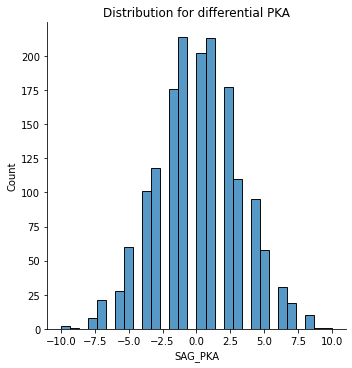

In [142]:
##example drawing for differential data
sns_plot = sns.displot(differential_data["SAG_PKA"])

plt.title(f"Distribution for differential PKA")
plt.show()

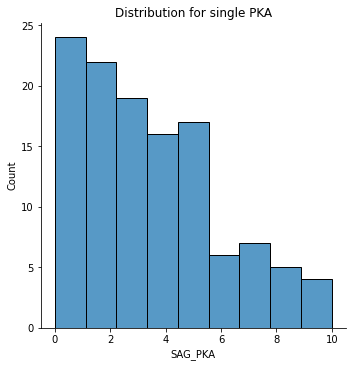

In [143]:
##example drawing for non-differential data
sns_plot2 = sns.displot(extra_dataH["SAG_PKA"])

plt.title(f"Distribution for single PKA")
plt.show()

In [144]:
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,Season
0,19/08/2000,Charlton,Man City,4,0,H,2,0,H,Rob Harris,17,8,14,4,6,6,13,12,1,2,0,0,2000
1,19/08/2000,Chelsea,West Ham,4,2,H,1,0,H,Graham Barber,17,12,10,5,7,7,19,14,1,2,0,0,2000
2,19/08/2000,Coventry,Middlesbrough,1,3,A,1,1,D,Barry Knight,6,16,3,9,8,4,15,21,5,3,1,0,2000
3,19/08/2000,Derby,Southampton,2,2,D,1,2,A,Andy D'Urso,6,13,4,6,5,8,11,13,1,1,0,0,2000
4,19/08/2000,Leeds,Everton,2,0,H,2,0,H,Dermot Gallagher,17,12,8,6,6,4,21,20,1,3,0,0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,29/10/2022,Newcastle,Aston Villa,4,0,H,1,0,H,P Tierney,20,3,7,0,3,0,11,11,1,1,0,0,2022
8482,29/10/2022,Fulham,Everton,0,0,D,0,0,D,J Brooks,24,9,6,4,13,4,10,8,2,1,0,0,2022
8483,29/10/2022,Liverpool,Leeds,1,2,A,1,1,D,M Oliver,22,14,10,6,14,5,9,3,0,1,0,0,2022
8484,30/10/2022,Arsenal,Nott'm Forest,5,0,H,1,0,H,S Hooper,24,5,10,2,9,4,9,8,0,1,0,0,2022


In [145]:
#add what we want to predict in the column
def add_NR(group):
    group["NR"] = group["FTR"].shift(-1)
    return group
df = df.groupby("HomeTeam", group_keys=False).apply(add_NR)
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,Season,NR
0,19/08/2000,Charlton,Man City,4,0,H,2,0,H,Rob Harris,17,8,14,4,6,6,13,12,1,2,0,0,2000,D
1,19/08/2000,Chelsea,West Ham,4,2,H,1,0,H,Graham Barber,17,12,10,5,7,7,19,14,1,2,0,0,2000,D
2,19/08/2000,Coventry,Middlesbrough,1,3,A,1,1,D,Barry Knight,6,16,3,9,8,4,15,21,5,3,1,0,2000,A
3,19/08/2000,Derby,Southampton,2,2,D,1,2,A,Andy D'Urso,6,13,4,6,5,8,11,13,1,1,0,0,2000,D
4,19/08/2000,Leeds,Everton,2,0,H,2,0,H,Dermot Gallagher,17,12,8,6,6,4,21,20,1,3,0,0,2000,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,29/10/2022,Newcastle,Aston Villa,4,0,H,1,0,H,P Tierney,20,3,7,0,3,0,11,11,1,1,0,0,2022,NaN
8482,29/10/2022,Fulham,Everton,0,0,D,0,0,D,J Brooks,24,9,6,4,13,4,10,8,2,1,0,0,2022,NaN
8483,29/10/2022,Liverpool,Leeds,1,2,A,1,1,D,M Oliver,22,14,10,6,14,5,9,3,0,1,0,0,2022,NaN
8484,30/10/2022,Arsenal,Nott'm Forest,5,0,H,1,0,H,S Hooper,24,5,10,2,9,4,9,8,0,1,0,0,2022,NaN


In [146]:
#combine two dataset together
frames = [df,differential_data ]
df = pd.concat(frames,axis=1)
df = df.dropna()
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,Season,NR,SAG_GA,SAG_PKA,SAG_FK,SAG_CK,SAG_OG,SAG_PSxG,SAG_PSxG/SoT,SAG_PSxG+/-,SAG_/90,SAG_Cmp,SAG_Att,SAG_Cmp%,SAG_Att.1,SAG_Thr,SAG_Launch%,SAG_AvgLen,SAG_G+A-PK,SAG_Launch%.1,SAG_AvgLen.1,SAG_Opp,SAG_Stp,SAG_Stp%,SAG_#OPA,SAG_#OPA/90,SAG_AvgDist,SDA_Tkl,SDA_TklW,SDA_Def3rd,SDA_Mid3rd,SDA_Att3rd,SDA_Tkl.1,SDA_Att,SDA_Tkl%,SDA_Past,SDA_Blocks,SDA_Sh,SDA_Pass,SDA_Int,SDA_Tkl+Int,SDA_Clr,SDA_Err,SGSC_SCA,SGSC_SCA90,SGSC_PassLive,SGSC_PassDead,SGSC_Drib,SGSC_Sh,SGSC_Fld,SGSC_Def,SGSC_GCA,SGSC_GCA90,SGSC_PassLive.1,SGSC_PassDead.1,SGSC_Drib.1,SGSC_Sh.1,SGSC_Fld.1,SGSC_Def.1,SM_CrdY,SM_CrdR,SM_2CrdY,SM_Fls,SM_Fld,SM_Off,SM_Crs,SM_Int,SM_TklW,SM_PKwon,SM_PKcon,SM_OG,SM_Recov,SM_Won,SM_Lost,SM_Won%,PT_Att,PT_Live,PT_Dead,PT_FK,PT_TB,PT_Sw,PT_Crs,PT_TI,PT_CK,PT_In,PT_Out,PT_Str,PT_Cmp,PT_Off,PT_Blocks,P_Cmp,P_Att,P_Cmp%,P_TotDist,P_PrgDist,P_Cmp.1,P_Att.1,P_Cmp%.1,P_Cmp.2,P_Att.2,P_Cmp%.2,P_Cmp.3,P_Att.3,P_Cmp%.3,P_Ast,P_xAG,P_xA,P_A-xAG,P_KP,P_1/3,P_PPA,P_CrsPA,P_Prog,SPT_Age,SPT_MP,SPT_Mn/MP,SPT_Min%,SPT_90s,SPT_Start,SPT_Mn/Start,SPT_Compl,SPT_Subs,SPT_Mn/Sub,SPT_unSub,SPT_PPM,SPT_onG,SPT_onGA,SPT_+/-,SPT_+/-90,SPT_onxG,SPT_onxGA,SPT_xG+/-,SPT_xG+/-90,SP_Poss,SP_90s,SP_Touches,SP_DefPen,SP_Def3rd,SP_Mid3rd,SP_Att3rd,SP_AttPen,SP_Live,SP_Succ,SP_Att,SP_Succ%,SP_Mis,SP_Dis,SP_Rec,SP_Prog,SS_Gls,SS_Sh,SS_SoT,SS_SoT%,SS_Sh/90,SS_SoT/90,SS_G/Sh,SS_G/SoT,SS_Dist,SS_FK,SS_PK,SS_PKatt,SS_xG,SS_npxG,SS_npxG/Sh,SS_G-xG,SS_np:G-xG,SSS_Age,SSS_Poss,SSS_MP,SSS_Starts,SSS_90s,SSS_Gls,SSS_Ast,SSS_G-PK,SSS_PK,SSS_PKatt,SSS_CrdY,SSS_CrdR,SSS_Gls.1,SSS_Ast.1,SSS_G+A,SSS_G-PK.1,SSS_G+A-PK,SSS_xG,SSS_npxG,SSS_xAG,SSS_npxG+xAG,SSS_xG.1,SSS_xAG.1,SSS_xG+xAG,SSS_npxG.1,SSS_npxG+xAG.1,RS_xG,RS_xGA,RS_xGD,RS_xGD/90
6840,10/08/2018,Man United,Leicester,2,1,H,1,0,H,A Marriner,8,13,6,4,2,5,11,8,2,1,0,0,2018,A,32,1,2,6,0,11.1,0.01,-20.9,-0.55,100,248,0.6,156,-18,11.9,3.9,10,15.7,7.5,62,11,1.6,45,1.19,3.7,66,48,57,31,-22,35,61,2.6,26,83,18,65,-67,-1,81,-3,-188,-4.95,-205,29,-8,0,0,-4,-23,-0.61,-13,2,-6,-7,2,-1,0.0,0.0,4,-41,-65,4,-9,-67,48,5,3,0,21,170,259,-4.5,-4741,-4883,138,-32,-22,-6,-9,145,-17,26,-37,-1,-5408,4,-28,-5408,-4741,-9.0,-66319,-12970,-2931,-2751,-6.8,-1844,-1594,-8.1,-31,299,-5.8,-15,-5.6,-11.1,-9.4,-80,-314,-132,-1,-285,0.5,0,0,0,0,0,0.0,0.0,-4,0,4,-0.89,-12,32,-44,-1.16,-5.7,7.4,-13.1,-0.35,-6.7,0,-4552,7,-473,-1915,-2113,-218,-4556,-44,-18,-4.5,4,-41,-5420,-281,-14,-92,-33,-0.5,-2.42,-0.86,-0.01,-0.04,-0.8,-10,4,3,-5.7,-8.0,0.0,-8.3,-10.0,0.5,-6.7,0,0,0,-14,-15,-18,4,3,0.0,0.0,-0.37,-0.39,-0.77,-0.48,-0.87,-5.7,-8.0,-5.6,-13.6,-0.15,-0.15,-0.29,-0.21,-0.36,-5.7,7.4,-13.1,-0.35
6841,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,12,10,4,1,7,4,11,9,1,1,0,0,2018,D,-1,0,1,4,1,-4.3,-0.02,-2.3,-0.06,115,228,4.1,141,-81,14.7,4.6,-21,12.1,7.8,-48,-7,-0.7,48,1.27,6.2,121,93,60,62,-1,10,91,-3.9,81,12,-30,42,47,168,-122,-8,-81,-2.13,-87,5,8,2,-1,-8,11,0.29,15,0,1,-3,0,-2,0.0,0.0,3,25,-54,40,37,47,93,4,1,1,198,89,2,2.9,-838,-828,-50,-110,26,58,37,97,-15,33,-37,-1,-1093,40,-42,-1093,-838,-2.7,-25035,-11250,-94,-206,1.1,-1385,-1411,-4.0,82,254,-1.5,2,5.8,0.8,-3.8,-51,-210,-66,5,-208,0.3,0,0,0,0,0,0.0,0.0,-2,0,2,0.08,11,-1,12,0.31,11.2,-11.1,22.3,0.59,-0.1,0,-918,-198,-1129,641,-407,-107,-921,79,80,5.0,-48,-61,-1109,-208,8,-45,-16,-0.2,-1.19,-0.42,0.03,0.08,-0.7,-4,2,3,11.2,8.9,0.03,-3.2,-2.9,0.3,-0.1,0,0,0,8,2,6,2,3,0.0,0.0,0.21,0.05,0.26,0.15,0.21,11.2,8.9,5.8,14.7,0.3,0.15,0.45,0.23,0.39,11.2,-11.1,22.3,0.59
6842,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,15,10,6,9,5,5,9,11,1,2,0,0,2018,H,-6,0,-1,4,1,-3.3,-0.01,3.7,0.1,89,179,3.3,-55,-105,22.8,7.8,-12,11.6,7.3,1,2,0.3,14,0.37,3.3,177,123,121,50,6,62,141,1.3,79,13,-43,56,185,362,-19,-3,25,0.66,-54,5,38,13,21,2,-5,-0.13,-3,-5,2,1,2,-2,0.0,0.0,-1,86,-7,4,-4,185,123,7,-1,1,200,54,-42,3.3,-1848,-1765,-87,-78,-7,-29,-4,17,-8,-19,-28,67,-1641,4,-51,-1641,-1848,-1.6,-42619,-10305,88,-144,3.1,-1584,-

In [147]:
#change the result of the game to number
df['NR'].replace(['H', 'D', 'A'], [1, 0, -1], inplace=True)
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,Season,NR,SAG_GA,SAG_PKA,SAG_FK,SAG_CK,SAG_OG,SAG_PSxG,SAG_PSxG/SoT,SAG_PSxG+/-,SAG_/90,SAG_Cmp,SAG_Att,SAG_Cmp%,SAG_Att.1,SAG_Thr,SAG_Launch%,SAG_AvgLen,SAG_G+A-PK,SAG_Launch%.1,SAG_AvgLen.1,SAG_Opp,SAG_Stp,SAG_Stp%,SAG_#OPA,SAG_#OPA/90,SAG_AvgDist,SDA_Tkl,SDA_TklW,SDA_Def3rd,SDA_Mid3rd,SDA_Att3rd,SDA_Tkl.1,SDA_Att,SDA_Tkl%,SDA_Past,SDA_Blocks,SDA_Sh,SDA_Pass,SDA_Int,SDA_Tkl+Int,SDA_Clr,SDA_Err,SGSC_SCA,SGSC_SCA90,SGSC_PassLive,SGSC_PassDead,SGSC_Drib,SGSC_Sh,SGSC_Fld,SGSC_Def,SGSC_GCA,SGSC_GCA90,SGSC_PassLive.1,SGSC_PassDead.1,SGSC_Drib.1,SGSC_Sh.1,SGSC_Fld.1,SGSC_Def.1,SM_CrdY,SM_CrdR,SM_2CrdY,SM_Fls,SM_Fld,SM_Off,SM_Crs,SM_Int,SM_TklW,SM_PKwon,SM_PKcon,SM_OG,SM_Recov,SM_Won,SM_Lost,SM_Won%,PT_Att,PT_Live,PT_Dead,PT_FK,PT_TB,PT_Sw,PT_Crs,PT_TI,PT_CK,PT_In,PT_Out,PT_Str,PT_Cmp,PT_Off,PT_Blocks,P_Cmp,P_Att,P_Cmp%,P_TotDist,P_PrgDist,P_Cmp.1,P_Att.1,P_Cmp%.1,P_Cmp.2,P_Att.2,P_Cmp%.2,P_Cmp.3,P_Att.3,P_Cmp%.3,P_Ast,P_xAG,P_xA,P_A-xAG,P_KP,P_1/3,P_PPA,P_CrsPA,P_Prog,SPT_Age,SPT_MP,SPT_Mn/MP,SPT_Min%,SPT_90s,SPT_Start,SPT_Mn/Start,SPT_Compl,SPT_Subs,SPT_Mn/Sub,SPT_unSub,SPT_PPM,SPT_onG,SPT_onGA,SPT_+/-,SPT_+/-90,SPT_onxG,SPT_onxGA,SPT_xG+/-,SPT_xG+/-90,SP_Poss,SP_90s,SP_Touches,SP_DefPen,SP_Def3rd,SP_Mid3rd,SP_Att3rd,SP_AttPen,SP_Live,SP_Succ,SP_Att,SP_Succ%,SP_Mis,SP_Dis,SP_Rec,SP_Prog,SS_Gls,SS_Sh,SS_SoT,SS_SoT%,SS_Sh/90,SS_SoT/90,SS_G/Sh,SS_G/SoT,SS_Dist,SS_FK,SS_PK,SS_PKatt,SS_xG,SS_npxG,SS_npxG/Sh,SS_G-xG,SS_np:G-xG,SSS_Age,SSS_Poss,SSS_MP,SSS_Starts,SSS_90s,SSS_Gls,SSS_Ast,SSS_G-PK,SSS_PK,SSS_PKatt,SSS_CrdY,SSS_CrdR,SSS_Gls.1,SSS_Ast.1,SSS_G+A,SSS_G-PK.1,SSS_G+A-PK,SSS_xG,SSS_npxG,SSS_xAG,SSS_npxG+xAG,SSS_xG.1,SSS_xAG.1,SSS_xG+xAG,SSS_npxG.1,SSS_npxG+xAG.1,RS_xG,RS_xGA,RS_xGD,RS_xGD/90
6840,10/08/2018,Man United,Leicester,2,1,H,1,0,H,A Marriner,8,13,6,4,2,5,11,8,2,1,0,0,2018,-1,32,1,2,6,0,11.1,0.01,-20.9,-0.55,100,248,0.6,156,-18,11.9,3.9,10,15.7,7.5,62,11,1.6,45,1.19,3.7,66,48,57,31,-22,35,61,2.6,26,83,18,65,-67,-1,81,-3,-188,-4.95,-205,29,-8,0,0,-4,-23,-0.61,-13,2,-6,-7,2,-1,0.0,0.0,4,-41,-65,4,-9,-67,48,5,3,0,21,170,259,-4.5,-4741,-4883,138,-32,-22,-6,-9,145,-17,26,-37,-1,-5408,4,-28,-5408,-4741,-9.0,-66319,-12970,-2931,-2751,-6.8,-1844,-1594,-8.1,-31,299,-5.8,-15,-5.6,-11.1,-9.4,-80,-314,-132,-1,-285,0.5,0,0,0,0,0,0.0,0.0,-4,0,4,-0.89,-12,32,-44,-1.16,-5.7,7.4,-13.1,-0.35,-6.7,0,-4552,7,-473,-1915,-2113,-218,-4556,-44,-18,-4.5,4,-41,-5420,-281,-14,-92,-33,-0.5,-2.42,-0.86,-0.01,-0.04,-0.8,-10,4,3,-5.7,-8.0,0.0,-8.3,-10.0,0.5,-6.7,0,0,0,-14,-15,-18,4,3,0.0,0.0,-0.37,-0.39,-0.77,-0.48,-0.87,-5.7,-8.0,-5.6,-13.6,-0.15,-0.15,-0.29,-0.21,-0.36,-5.7,7.4,-13.1,-0.35
6841,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,12,10,4,1,7,4,11,9,1,1,0,0,2018,0,-1,0,1,4,1,-4.3,-0.02,-2.3,-0.06,115,228,4.1,141,-81,14.7,4.6,-21,12.1,7.8,-48,-7,-0.7,48,1.27,6.2,121,93,60,62,-1,10,91,-3.9,81,12,-30,42,47,168,-122,-8,-81,-2.13,-87,5,8,2,-1,-8,11,0.29,15,0,1,-3,0,-2,0.0,0.0,3,25,-54,40,37,47,93,4,1,1,198,89,2,2.9,-838,-828,-50,-110,26,58,37,97,-15,33,-37,-1,-1093,40,-42,-1093,-838,-2.7,-25035,-11250,-94,-206,1.1,-1385,-1411,-4.0,82,254,-1.5,2,5.8,0.8,-3.8,-51,-210,-66,5,-208,0.3,0,0,0,0,0,0.0,0.0,-2,0,2,0.08,11,-1,12,0.31,11.2,-11.1,22.3,0.59,-0.1,0,-918,-198,-1129,641,-407,-107,-921,79,80,5.0,-48,-61,-1109,-208,8,-45,-16,-0.2,-1.19,-0.42,0.03,0.08,-0.7,-4,2,3,11.2,8.9,0.03,-3.2,-2.9,0.3,-0.1,0,0,0,8,2,6,2,3,0.0,0.0,0.21,0.05,0.26,0.15,0.21,11.2,8.9,5.8,14.7,0.3,0.15,0.45,0.23,0.39,11.2,-11.1,22.3,0.59
6842,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,15,10,6,9,5,5,9,11,1,2,0,0,2018,1,-6,0,-1,4,1,-3.3,-0.01,3.7,0.1,89,179,3.3,-55,-105,22.8,7.8,-12,11.6,7.3,1,2,0.3,14,0.37,3.3,177,123,121,50,6,62,141,1.3,79,13,-43,56,185,362,-19,-3,25,0.66,-54,5,38,13,21,2,-5,-0.13,-3,-5,2,1,2,-2,0.0,0.0,-1,86,-7,4,-4,185,123,7,-1,1,200,54,-42,3.3,-1848,-1765,-87,-78,-7,-29,-4,17,-8,-19,-28,67,-1641,4,-51,-1641,-1848,-1.6,-42619,-10305,88,-144,3.1,-1584,

In [148]:
#find correlation of each feature to target 
df = df.drop(columns=['Date', 'HomeTeam',"AwayTeam","FTR","HTR","Referee"])
df = df.astype(float)
stat_cols = list(df.keys())

stat_correlations = df[stat_cols].corr().abs()
stat_correlations['NR'].sort_values()

SAG_PSxG+/-        0.000046
SAG_/90            0.000197
SAG_Att.1          0.000985
SS_Dist            0.003046
Season             0.003363
SSS_CrdR           0.004887
SM_CrdR            0.004887
AR                 0.006393
PT_FK              0.008645
P_CrsPA            0.010032
SP_Def3rd          0.010199
SGSC_Def           0.010202
SM_2CrdY           0.013391
SGSC_Fld           0.015092
SM_Fld             0.015634
PT_In              0.016621
HR                 0.019855
PT_Off             0.024167
SM_Off             0.024167
SAG_Cmp%           0.027078
SPT_Mn/Start       0.028092
SAG_PKA            0.028224
SP_Dis             0.028638
SGSC_PassDead      0.029126
SPT_Compl          0.029189
SPT_Mn/Sub         0.029616
SAG_Stp%           0.031248
SM_PKcon           0.031544
SM_Won%            0.034487
AF                 0.034891
SDA_Pass           0.034983
SGSC_PassDead.1    0.037467
SP_Mis             0.037652
PT_TI              0.038002
SDA_Tkl%           0.039980
SM_Recov           0

In [149]:
# EXTRA FEATURES

DataCopy = pd.read_csv("epl-training-with-seasons.csv") # This is a copy of the original EPL training data set, but with a column indicating the season of the match

print(DataCopy.iloc[0:5,-2:])

ExtraFeatures = pd.read_csv("extra_features.csv") # This is a dataset that contains the SPT_PPM and SPT_+/- for each team in each season
# PPM = points won per match
# +/- = goals scored minus goals allowed by the team while the player was on the pitch per 90 minutes played
print(ExtraFeatures.iloc[0:5])

   AR  Season
0   0    2000
1   0    2000
2   0    2000
3   0    2000
4   0    2000
      HomeTeam  Season  SPT_PPM  SPT_+/-  SS_SoT  SS_Gls
0      Arsenal    2022     2.64       22      77      32
1  Aston Villa    2022     1.20       -6      56      16
2  Bournemouth    2022     1.07      -14      48      18
3    Brentford    2022     1.27       -2      58      23
4     Brighton    2022     1.50        4      69      20


In [150]:
data = pd.concat([data,  DataCopy[("Season")]], axis=1)

print(data.iloc[0:5,-2:])


    AR  Season
0  0.0    2000
1  0.0    2000
2  0.0    2000
3  0.0    2000
4  0.0    2000


In [151]:

Features = pd.concat([Features, pd.DataFrame(np.nan, index=Features.index, columns=["HSPT_PPM","HSPT_+/-","ASPT_PPM","ASPT_+/-"])], axis=1)

print(Features.iloc[0:5,-2:])

   ASPT_PPM  ASPT_+/-
0       NaN       NaN
1       NaN       NaN
2       NaN       NaN
3       NaN       NaN
4       NaN       NaN


In [152]:
#Row = ExtraFeatures[(ExtraFeatures['HomeTeam'] == HomeTeam) & (ExtraFeatures['Season'] == Season - 1) ]

Row = ExtraFeatures[(ExtraFeatures['HomeTeam'] == 'Chelsea') & (ExtraFeatures['Season'] == 2021) ]
print(Row.shape[0])
print(Row)
Points = Row.iloc[0, Row.columns.get_loc('SPT_PPM')]
PlusMinus = Row.iloc[0, Row.columns.get_loc('SPT_+/-')]
print(Points)
print(PlusMinus)

1
   HomeTeam  Season  SPT_PPM  SPT_+/-  SS_SoT  SS_Gls
25  Chelsea    2021     1.95       43     200      75
1.95
43


In [153]:
Row = ExtraFeatures[ExtraFeatures['Season'] == 2000].quantile(0.1,numeric_only=True)

print(Row.shape[0])

print(Row)

5
Season     2000.00
SPT_PPM       0.89
SPT_+/-     -24.30
SS_SoT      158.50
SS_Gls       35.70
Name: 0.1, dtype: float64


In [154]:
Points = Row['SPT_PPM']
print(Points)


0.89


In [155]:
# BOTH TEAMS IN A MATCH WILL NOW HAVE THEIR PREVIOUS SEASON'S PPM AND +/- STAT ADDED AS A FEATURE FOR THAT MATCH
# IF THE TEAM WAS NOT PRESENT IN THE PREVIOUS SEASON, THE SEASON'S MEAN STATS WILL BE ADDED INSTEAD

for i in range (data.shape[0]):
    HomeTeam = data.iloc[i, data.columns.get_loc("HomeTeam")] # Take team names
    AwayTeam = data.iloc[i, data.columns.get_loc("AwayTeam")]
    Season = int(data.iloc[i, data.columns.get_loc("Season")]) - 1

    if Season != 1999:
        # Home team previous season stats
        Row = ExtraFeatures[(ExtraFeatures['HomeTeam'] == HomeTeam) & (ExtraFeatures['Season'] == Season) ]

        if Row.shape[0] == 0: # If the row is empty the team was not present in the previous season
            Row = ExtraFeatures[ExtraFeatures['Season'] == Season].quantile(0.1,numeric_only=True) # Use that season's 10th percentile instead
            Points = Row['SPT_PPM']
            PlusMinus = Row['SPT_+/-']

        else:
            Points = Row.iloc[0, Row.columns.get_loc('SPT_PPM')]
            PlusMinus = Row.iloc[0, Row.columns.get_loc('SPT_+/-')]

        Features.iloc[i, Features.columns.get_loc("HSPT_PPM")] = Points
        Features.iloc[i, Features.columns.get_loc("HSPT_+/-")] = PlusMinus

        # Away team previous season stats
        Row = ExtraFeatures[(ExtraFeatures['HomeTeam'] == AwayTeam) & (ExtraFeatures['Season'] == Season ) ]
        # The teams column in the ExtraFeatures dataframe is called HomeTeam but can be applied to both home and away teams in the Features dataframe

        if Row.shape[0] == 0:
            Row = ExtraFeatures[ExtraFeatures['Season'] == Season].quantile(0.1,numeric_only=True) # If the row is empty
            Points = Row['SPT_PPM']
            PlusMinus = Row['SPT_+/-']

        else:
            Points = Row.iloc[0, Row.columns.get_loc('SPT_PPM')]
            PlusMinus = Row.iloc[0, Row.columns.get_loc('SPT_+/-')]

        Features.iloc[i, Features.columns.get_loc("ASPT_PPM")] = Points
        Features.iloc[i, Features.columns.get_loc("ASPT_+/-")] = PlusMinus

In [156]:
# REMOVE ONLY ROWS OF NAN, MOST ARE 20 YEAR + OLD MATCHES IN 2000 SO PROBABLY WONT HAVE A BIG EFFECT

# NANS EXIST FOR TEANS FOR WHOM THERE WAS NO PRIOR INFORMATION IN THE DATASETS

# FOR EXAMPLE NOTTINGHAM FOREST'S FIRST GAMES WERE IN 2022, SO THERE ARE TWO NANS FOR THAT TEAM;

# ONE FOR THEIR FIST HOME GAME AND ONE FOR THEIR FIRST AWAY GAME

nan_values =Features[Features.isna().any(axis=1)]

print(nan_values.shape[0])

print(nan_values.iloc[0:5,-6:])

print(nan_values.iloc[-5:,-6:])

Features = Features.dropna()

429
   AFTR  AHTR  HSPT_PPM  HSPT_+/-  ASPT_PPM  ASPT_+/-
0   NaN   NaN       NaN       NaN       NaN       NaN
1   NaN   NaN       NaN       NaN       NaN       NaN
2   NaN   NaN       NaN       NaN       NaN       NaN
3   NaN   NaN       NaN       NaN       NaN       NaN
4   NaN   NaN       NaN       NaN       NaN       NaN
          AFTR      AHTR  HSPT_PPM  HSPT_+/-  ASPT_PPM  ASPT_+/-
6477 -0.284211 -0.164912     0.875     -29.2     0.875     -29.2
7980  0.167920  0.095238     0.734     -27.5     1.610      16.0
7992       NaN       NaN     1.160     -25.0     0.734     -27.5
8364       NaN       NaN     1.290     -18.0     0.889     -37.6
8377 -0.254848 -0.168975     0.889     -37.6     1.470       9.0


In [157]:
# SCALE FEATURES USING MIX MAX SCALER
removed_columns = ["FTR", "Year", "Month", "Day"]
selected_columns = Features.columns[~Features.columns.isin(removed_columns)]
scaler = MinMaxScaler()
Features[selected_columns] = scaler.fit_transform(Features[selected_columns])
Features = Features.reset_index(drop='True')
#Features.to_csv('Features.csv')  

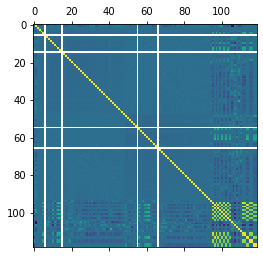

In [158]:
# VISUALISE CORRELATION BETWEEN FEATURES
plt.matshow(Features.corr())
plt.show()


(8057, 119)
94


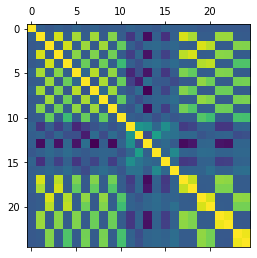

In [159]:
print(Features.shape)
print(Features.columns.get_loc("AT-DT-Km"))
# VISUALISE FEATURES THAT ARE NOT THE BINARY HOME AND AWAY TEAM FEATURES
plt.matshow(Features.iloc[:,94:119].corr())
plt.show()

Text(0.5, 1.0, 'Feature Correlation Matrix')

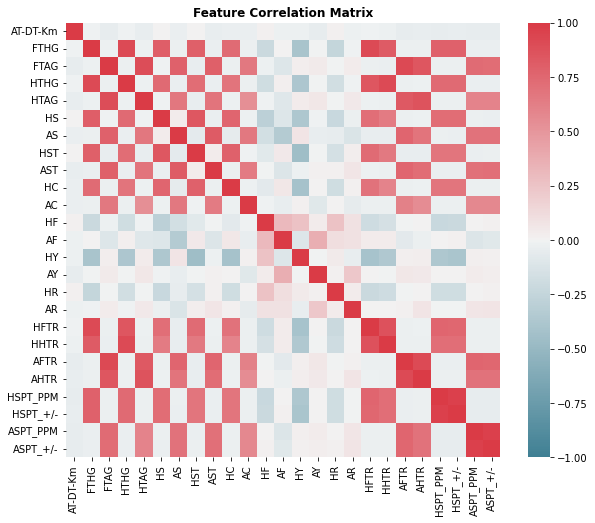

In [160]:
# FEATURE CORRELATION MATRIX
f, ax = plt.subplots(figsize=(10, 8))
corr = Features.iloc[:,94:119].corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize = 12, fontweight ='bold')

# Code from https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

In [161]:
# CREATE TRAIN, VALIDATION AND TEST SETS

Train = Features[Features["Year"] < 2021] # Split data chronologically
ValidateTest =  Features[Features["Year"] >= 2021 ]
Validate = ValidateTest[ValidateTest["Year"] < 2022]
Test = ValidateTest[ValidateTest["Year"] >= 2022]

Y_Train = Train["FTR"]
Y_Validate = Validate["FTR"]
Y_Test = Test["FTR"]

# DROP DATE AFTER SPLITTING DATA

X_Train = Train.drop(columns = ["FTR", "Year", "Month", "Day"])
X_Validate = Validate.drop(columns = ["FTR", "Year", "Month", "Day"])
X_Test = Test.drop(columns = ["FTR", "Year", "Month", "Day"])


0.46105919003115264


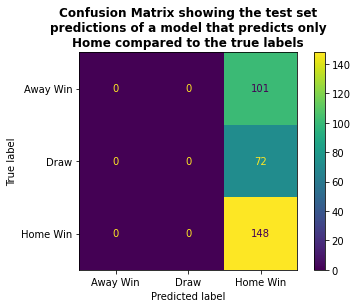

In [162]:
# MODEL TRANING, HYPERPARAMETER SELECTION AND VALIDATION

# CREATE MODEL THAT ONLY PREDICTS HOME WINS
Predictions = Y_Test.copy()
Predictions[:] = 2
Accuracy = accuracy_score(Y_Test,Predictions)
print(Accuracy)
confusion_matrix = metrics.confusion_matrix(Y_Test, Predictions)

Matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Away Win', 'Draw', 'Home Win'])
# Home win = 2, Draw = 1, Away win = 0 
Matrix.plot()
Matrix.ax_.set_title("Confusion Matrix showing the test set\npredictions of a model that predicts only\nHome compared to the true labels", fontsize = 12, fontweight ='bold')
plt.show()

In [169]:
# RANDOM FOREST MODEL TRANING, HYPERPARAMETER SELECTION AND VALIDATION

highestAccuracy = 0
nchoice = 0
RFindex = 0
RF_n_List = []
RF_TrainAccuracy_List = []
RF_ValidateAccuracy_List = []
RF_Model_List = []
RF_n_List.clear()
RF_TrainAccuracy_List.clear()
RF_ValidateAccuracy_List.clear()
RF_Model_List.clear()

for i in range(0, 22, 1):

    n = (i+1)*10

    RF_n_List.append(n)

    rf = RandomForestClassifier(n_estimators=n)

    rf.fit(X_Train,Y_Train)
    #
    TrainPredictions = rf.predict(X_Train)

    TrainAccuracy = accuracy_score(Y_Train,TrainPredictions)

    RF_TrainAccuracy_List.append(TrainAccuracy)
    #
    ValidatePredictions = rf.predict(X_Validate)

    ValidateAccuracy = accuracy_score(Y_Validate,ValidatePredictions)

    RF_ValidateAccuracy_List.append(ValidateAccuracy)
    
    RF_Model_List.append(rf)

    if ValidateAccuracy > highestAccuracy:
        highestAccuracy = ValidateAccuracy
        RFindex = i


In [170]:
# PRINT TABLE OF ACCURACY RESULTS

print("The number of estimators, " +str(RF_n_List[RFindex]) + ", that gave the highest validation accuracy of " +str(highestAccuracy) +" corresponds to the model at index " + str(RFindex)+ " in the RF Model List.")

RandomForestTable = pd.DataFrame(list(zip(RF_n_List, RF_TrainAccuracy_List, RF_ValidateAccuracy_List)), columns =['Number of Estimators', 'Training Accuracy','Validation Accuracy']) 
print(RandomForestTable)

The number of estimators, 150, that gave the highest validation accuracy of 0.541871921182266 corresponds to the model at index 14 in the RF Model List.
    Number of Estimators  Training Accuracy  Validation Accuracy
0                     10           0.984993             0.421182
1                     20           0.997681             0.477833
2                     30           0.999318             0.522167
3                     40           0.999864             0.500000
4                     50           0.999727             0.507389
5                     60           1.000000             0.482759
6                     70           1.000000             0.522167
7                     80           1.000000             0.514778
8                     90           1.000000             0.507389
9                    100           1.000000             0.509852
10                   110           1.000000             0.514778
11                   120           1.000000             0.519704
12

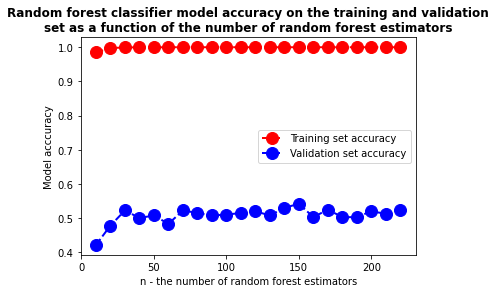

In [171]:
# PRINT GRAPH OF RESULTS OF BOTH THE TRAINING ACCURACY AND THE VALIDATION ACCURACY

fig, ax = plt.subplots()
ax.set_xlabel('n - the number of random forest estimators')
ax.set_ylabel('Model acccuracy')

ax.set_title('Random forest classifier model accuracy on the training and validation\nset as a function of the number of random forest estimators', fontsize = 12, fontweight ='bold')
ax.plot(RF_n_List, RF_TrainAccuracy_List, 'ro--', linewidth=2, markersize=12,label='Training set accuracy')
ax.plot(RF_n_List, RF_ValidateAccuracy_List, 'bo--', linewidth=2, markersize=12,label='Validation set accuracy')
ax.legend(loc='best')

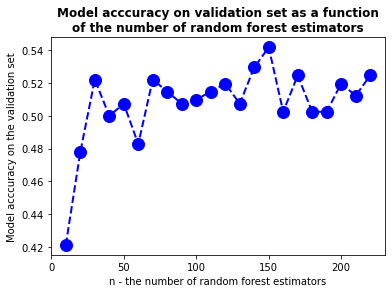

In [172]:
# PRINT JUST THE VALIDATION ACCURACY GRAPH

fig, ax = plt.subplots()
ax.set_xlabel('n - the number of random forest estimators')
ax.set_ylabel('Model acccuracy on the validation set')

ax.set_title('Model acccuracy on validation set as a function\nof the number of random forest estimators', fontsize = 12, fontweight ='bold')
ax.plot(RF_n_List, RF_ValidateAccuracy_List, 'bo--', linewidth=2, markersize=12)

In [173]:
# FINAL RANDOM FOREST MODEL

rf = RF_Model_List[RFindex]

print("Number of estimators = " + str(RF_n_List[RFindex]))

TrainPredictions = rf.predict(X_Train)

TrainAccuracy = accuracy_score(Y_Train,TrainPredictions)

ValidatePredictions = rf.predict(X_Validate)

ValidateAccuracy = accuracy_score(Y_Validate,ValidatePredictions)

print("Train accuracy = " + str(TrainAccuracy) )

print("Validation accuracy = " +str(ValidateAccuracy))

TestPredictions = rf.predict(X_Test)

TestAccuracy = accuracy_score(Y_Test,TestPredictions)

print("Test accuracy = " +str(TestAccuracy))

Number of estimators = 150
Train accuracy = 1.0
Validation accuracy = 0.541871921182266
Test accuracy = 0.5171339563862928


In [200]:
# Logistic Regression Model Training

highestAccuracy = 0
i = 0
LRindex = 0
LR_TrainAccuracy_List = []
LR_TrainAccuracy_List.clear()
LR_ValidateAccuracy_List = []
LR_ValidateAccuracy_List.clear()
LR_Model_List = []
LR_Model_List.clear()
LR_ModelDesc_List = []
LR_ModelDesc_List.clear()

# FIRST TEST NO PENALTY

LR = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', penalty = 'none', fit_intercept=True, tol = 1e-9, max_iter = 100000)

LR.fit(X_Train,Y_Train)

TrainPredictions = LR.predict(X_Train)

TrainAccuracy = accuracy_score(Y_Train,TrainPredictions)

ValidatePredictions = LR.predict(X_Validate)

ValidateAccuracy = accuracy_score(Y_Validate,ValidatePredictions)

LR_TrainAccuracy_List.append(TrainAccuracy)

LR_ValidateAccuracy_List.append(ValidateAccuracy)

LR_ModelDesc_List.append("penalty = 'none'")

LR_Model_List.append(LR)

if ValidateAccuracy > highestAccuracy:
    highestAccuracy = ValidateAccuracy
    LRindex = i

i = i + 1

# TEST L2 PENALTY OVER DIFFERENT C VALUES

c_values = [10000, 1000, 100, 10, 1.0, 0.1, 0.01]

for c in c_values:

    LR = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', penalty = 'l2', C=c, fit_intercept=True, tol = 1e-9, max_iter = 100000)

    LR.fit(X_Train,Y_Train)

    TrainPredictions = LR.predict(X_Train)

    TrainAccuracy = accuracy_score(Y_Train,TrainPredictions)

    ValidatePredictions = LR.predict(X_Validate)

    ValidateAccuracy = accuracy_score(Y_Validate,ValidatePredictions)

    LR_TrainAccuracy_List.append(TrainAccuracy)

    LR_ValidateAccuracy_List.append(ValidateAccuracy)

    LR_ModelDesc_List.append("penalty = 'l2', C = "+str(c))

    LR_Model_List.append(LR)

    if ValidateAccuracy > highestAccuracy:
        highestAccuracy = ValidateAccuracy
        LRindex = i

    i = i + 1


In [201]:
# PRINT TABLE OF ACCURACY RESULTS

print("The Logistic Regression Model, " +str(LR_ModelDesc_List[LRindex]) + ", that gave the highest validation accuracy of " +str(highestAccuracy) +" corresponds to the model at index " + str(LRindex)+ " in the LR Model List.")

RegressionTable = pd.DataFrame(list(zip(LR_ModelDesc_List, LR_TrainAccuracy_List, LR_ValidateAccuracy_List)), columns =['Model', 'Training Accuracy','Validation Accuracy']) 
print(RegressionTable)

The Logistic Regression Model, penalty = 'none', that gave the highest validation accuracy of 0.5123152709359606 corresponds to the model at index 0 in the LR Model List.
                       Model  Training Accuracy  Validation Accuracy
0           penalty = 'none'           0.547067             0.512315
1  penalty = 'l2', C = 10000           0.547203             0.512315
2   penalty = 'l2', C = 1000           0.547203             0.512315
3    penalty = 'l2', C = 100           0.547203             0.512315
4     penalty = 'l2', C = 10           0.547203             0.512315
5    penalty = 'l2', C = 1.0           0.543929             0.512315
6    penalty = 'l2', C = 0.1           0.539154             0.509852
7   penalty = 'l2', C = 0.01           0.534379             0.504926


In [227]:
# FINAL LOGISTIC REGRESSION MODEL

# Choose penalty of 'l2' and C = 100
LRindex = 3

LR = LR_Model_List[LRindex]

print(LR_ModelDesc_List[LRindex])

TrainPredictions = LR.predict(X_Train)

TrainAccuracy = accuracy_score(Y_Train,TrainPredictions)

ValidatePredictions = LR.predict(X_Validate)

ValidateAccuracy = accuracy_score(Y_Validate,ValidatePredictions)

print("Train accuracy = " + str(TrainAccuracy) )

print("Validation accuracy = " +str(ValidateAccuracy))

TestPredictions = LR.predict(X_Test)

TestAccuracy = accuracy_score(Y_Test,TestPredictions)

print("Test accuracy = " +str(TestAccuracy))

penalty = 'l2', C = 100
Train accuracy = 0.5472032742155525
Validation accuracy = 0.5123152709359606
Test accuracy = 0.5295950155763239


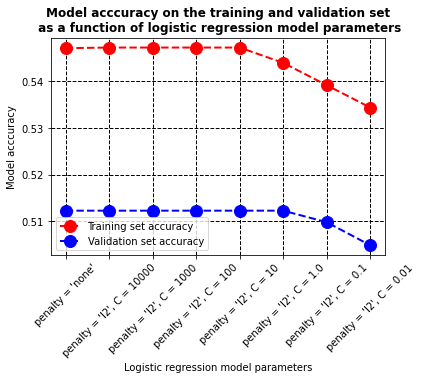

In [203]:
# PRINT GRAPH OF ACCURACY RESULTS

fig, ax = plt.subplots()
ax.set_xlabel('Logistic regression model parameters')
ax.set_ylabel('Model acccuracy')

ax.set_title('Model acccuracy on the training and validation set\n as a function of logistic regression model parameters', fontsize = 12, fontweight ='bold')
ax.grid(color='k', linestyle='--', linewidth=1,which='both')
ax.plot(LR_ModelDesc_List, LR_TrainAccuracy_List, 'ro--', linewidth=2, markersize=12,label='Training set accuracy')
ax.plot(LR_ModelDesc_List, LR_ValidateAccuracy_List, 'bo--', linewidth=2, markersize=12,label='Validation set accuracy')
plt.xticks(rotation=45)
ax.legend(loc='best')

In [204]:
# Support Vector Classifier Model Training

Kernels = ['linear','poly', 'rbf', 'sigmoid']
c_values = [10, 1.0, 0.1, 0.01]

highestAccuracy = 0
i = 0
SVCindex = 0

SVC_TrainAccuracy_List = []
SVC_TrainAccuracy_List.clear()
SVC_ValidateAccuracy_List = []
SVC_ValidateAccuracy_List.clear()
SVC_Model_List = []
SVC_Model_List.clear()
SVC_Kernel_List = []
SVC_Kernel_List.clear()
SVC_C_List = []
SVC_C_List.clear()

# Test Different Kernels

for k in Kernels:

    for c in c_values:

        SVCm = SVC(kernel = k, C = c)

        SVCm.fit(X_Train,Y_Train)

        TrainPredictions = SVCm.predict(X_Train)

        TrainAccuracy = accuracy_score(Y_Train,TrainPredictions)

        ValidatePredictions = SVCm.predict(X_Validate)

        ValidateAccuracy = accuracy_score(Y_Validate,ValidatePredictions)

        SVC_TrainAccuracy_List.append(TrainAccuracy)

        SVC_ValidateAccuracy_List.append(ValidateAccuracy)

        SVC_Kernel_List.append(str(k))
        SVC_C_List.append(str(c))

        SVC_Model_List.append(SVCm)

        if ValidateAccuracy > highestAccuracy:
            highestAccuracy = ValidateAccuracy
            SVCindex = i

        print(i, end = ' ')

        i = i + 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [205]:
# PRINT TABLE OF ACCURACY RESULTS OVER VARYING KERNELS AND C VALUES

print("The Support Vector Classifier Model, with kernel = " +str(SVC_Kernel_List[SVCindex]) + " and c = " +str(SVC_C_List[SVCindex]) + " , that gave the highest validation accuracy of " +str(highestAccuracy) +" corresponds to the model at index " + str(SVCindex)+ " in the SVC Model List.")

SVCKernelTable = pd.DataFrame(list(zip(SVC_Kernel_List, SVC_C_List, SVC_TrainAccuracy_List, SVC_ValidateAccuracy_List)), columns =['Kernel', 'C', 'Training Accuracy','Validation Accuracy']) 
print(SVCKernelTable)

The Support Vector Classifier Model, with kernel = linear and c = 10 , that gave the highest validation accuracy of 0.5369458128078818 corresponds to the model at index 0 in the SVC Model List.
     Kernel     C  Training Accuracy  Validation Accuracy
0    linear    10           0.529059             0.536946
1    linear   1.0           0.527831             0.529557
2    linear   0.1           0.526876             0.534483
3    linear  0.01           0.523738             0.529557
4      poly    10           0.643247             0.482759
5      poly   1.0           0.557572             0.519704
6      poly   0.1           0.533424             0.507389
7      poly  0.01           0.516371             0.507389
8       rbf    10           0.633834             0.500000
9       rbf   1.0           0.543520             0.522167
10      rbf   0.1           0.531924             0.514778
11      rbf  0.01           0.460709             0.401478
12  sigmoid    10           0.423192             0.4

Text(0.5, 1.0, 'Support vector classifier training accuracy over different kernel and c values')

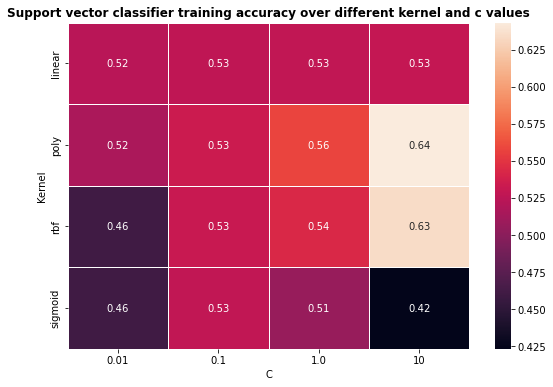

In [206]:
# PRINT HEAT MAPS DISPLAYING DATA FROM PREVIOUS TABLE/DATAFRAME

heatmapdata = SVCKernelTable.pivot("Kernel", "C", "Training Accuracy")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(heatmapdata, annot=True,  linewidths=.5, ax=ax)

ax.set_title('Support vector classifier training accuracy over different kernel and c values', fontsize = 12, fontweight ='bold')

Text(0.5, 1.0, 'Support vector classifier validation accuracy over different kernel and c values')

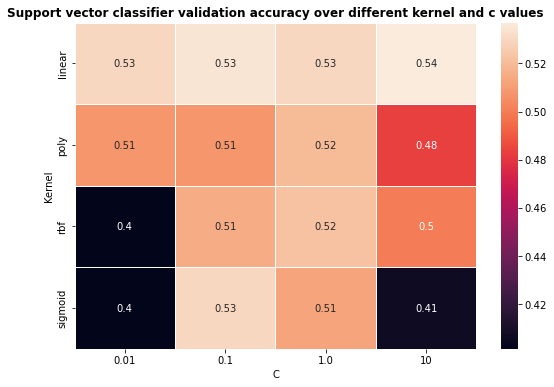

In [207]:
heatmapdata = SVCKernelTable.pivot("Kernel", "C", "Validation Accuracy")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(heatmapdata, annot=True,  linewidths=.5, ax=ax)

ax.set_title('Support vector classifier validation accuracy over different kernel and c values', fontsize = 12, fontweight ='bold')

In [208]:

highestAccuracy = 0
i = 0
SVCindex = 0

SVC_TrainAccuracy_List.clear()
SVC_ValidateAccuracy_List.clear()
SVC_Model_List.clear()
SVC_C_List.clear()
SVC_gamma_List = []
SVC_gamma_List.clear()

# Test Different degree and gamma values

gamma = [10000000, 1, 'scale' ,0.01, 0.0000001]

for g in gamma:

    SVCm = SVC(kernel = 'linear' ,gamma = g, C = 10)

    SVCm.fit(X_Train,Y_Train)

    TrainPredictions = SVCm.predict(X_Train)

    TrainAccuracy = accuracy_score(Y_Train,TrainPredictions)

    ValidatePredictions = SVCm.predict(X_Validate)

    ValidateAccuracy = accuracy_score(Y_Validate,ValidatePredictions)

    SVC_TrainAccuracy_List.append(TrainAccuracy)

    SVC_ValidateAccuracy_List.append(ValidateAccuracy)

    SVC_gamma_List.append(str(g))

    if ValidateAccuracy > highestAccuracy:
        highestAccuracy = ValidateAccuracy
        SVCindex = i

    print(i, end = ' ')

    i = i + 1


0 1 2 3 4 

In [209]:
# PRINT TABLE OF RESULTS FOR VARYING C AND GAMMA VALUES

SVCgammaTable = pd.DataFrame(list(zip(SVC_gamma_List, SVC_TrainAccuracy_List, SVC_ValidateAccuracy_List)), columns = ['gamma', 'Training Accuracy','Validation Accuracy']) 
print(SVCgammaTable)

      gamma  Training Accuracy  Validation Accuracy
0  10000000           0.529059             0.536946
1         1           0.529059             0.536946
2     scale           0.529059             0.536946
3      0.01           0.529059             0.536946
4     1e-07           0.529059             0.536946


In [210]:
# Final Support Vector Classifier Model

fSVCm = SVC(kernel = 'linear', gamma = 'scale', C = 10)

fSVCm.fit(X_Train,Y_Train)

TrainPredictions = fSVCm.predict(X_Train)

TrainAccuracy = accuracy_score(Y_Train,TrainPredictions)

ValidatePredictions = fSVCm.predict(X_Validate)

ValidateAccuracy = accuracy_score(Y_Validate,ValidatePredictions)

print("model = " + str(fSVCm) + "\nTrain accuracy = " + str(TrainAccuracy) )

print("Validation accuracy = " +str(ValidateAccuracy))

TestPredictions = fSVCm.predict(X_Test)

TestAccuracy = accuracy_score(Y_Test,TestPredictions)

print("Test accuracy = " +str(TestAccuracy))
 

model = SVC(C=10, kernel='linear')
Train accuracy = 0.5290586630286493
Validation accuracy = 0.5369458128078818
Test accuracy = 0.5420560747663551


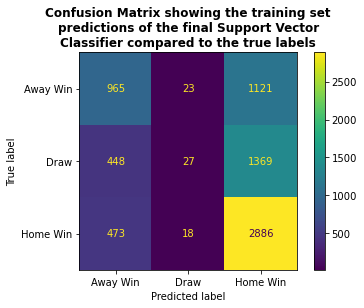

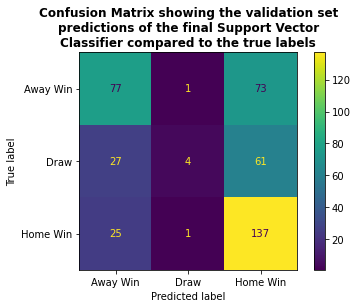

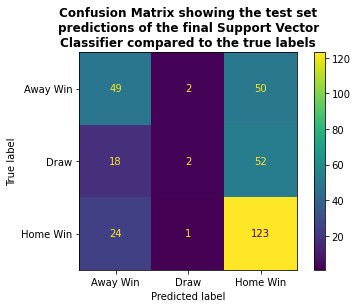

In [211]:
# CHOOSE SUPPORT VECTOR CLASSIFIER MODEL - BEST PERFORMANCE

# Plot Confusion Matrix for Final Support Vector Classifier Model

# Training Set
confusion_matrix = metrics.confusion_matrix(Y_Train, TrainPredictions)

Matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Away Win', 'Draw', 'Home Win'])
# Home win = 2, Draw = 1, Away win = 0 
Matrix.plot()
Matrix.ax_.set_title("Confusion Matrix showing the training set\npredictions of the final Support Vector\nClassifier compared to the true labels", fontsize = 12, fontweight ='bold')
plt.show()

# Validation Set
confusion_matrix = metrics.confusion_matrix(Y_Validate, ValidatePredictions)

Matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Away Win', 'Draw', 'Home Win'])
# Home win = 2, Draw = 1, Away win = 0 
Matrix.plot()
Matrix.ax_.set_title("Confusion Matrix showing the validation set\npredictions of the final Support Vector\nClassifier compared to the true labels", fontsize = 12, fontweight ='bold')
plt.show()

# Test Set
confusion_matrix = metrics.confusion_matrix(Y_Test, TestPredictions)

Matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Away Win', 'Draw', 'Home Win'])
# Home win = 2, Draw = 1, Away win = 0 
Matrix.plot()
Matrix.ax_.set_title("Confusion Matrix showing the test set\npredictions of the final Support Vector\nClassifier compared to the true labels", fontsize = 12, fontweight ='bold')
plt.show()

# DOES NOT LIKE PREDICTING DRAWS

Text(0.5, 1.0, 'Distribution of home wins, draws\nand away wins in the dataset')

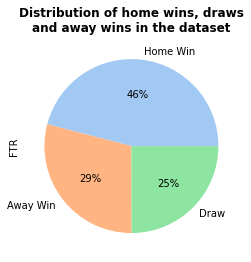

In [212]:
# PIE CHART SHOWING MATCH RESULT DISTRIBUTION TO COMPARE WITH CONFUSION MATRICES

data['FTR'].replace([1, 0, -1], ['Home Win', 'Draw', 'Away Win'], inplace=True)
ax = plt.subplots(facecolor=Colour)
colours = sns.color_palette('pastel')[0:5]
ax = data['FTR'].value_counts().plot(kind='pie', colors = colours, autopct='%.0f%%')
# set the title
ax.set_title("Distribution of home wins, draws\nand away wins in the dataset", fontsize = 12, fontweight ='bold')

In [213]:
# FINAL LOGISTIC REGRESSION MODEL
# JUST TO VISUALISE CONFUSION MATRICES

LR = LR_Model_List[LRindex]

print(LR_ModelDesc_List[LRindex])

TrainPredictions = LR.predict(X_Train)

TrainAccuracy = accuracy_score(Y_Train,TrainPredictions)

ValidatePredictions = LR.predict(X_Validate)

ValidateAccuracy = accuracy_score(Y_Validate,ValidatePredictions)

print("Train accuracy = " + str(TrainAccuracy) )

print("Validation accuracy = " +str(ValidateAccuracy))

TestPredictions = LR.predict(X_Test)

TestAccuracy = accuracy_score(Y_Test,TestPredictions)

print("Test accuracy = " +str(TestAccuracy))


penalty = 'none'
Train accuracy = 0.5470668485675307
Validation accuracy = 0.5123152709359606
Test accuracy = 0.5264797507788161


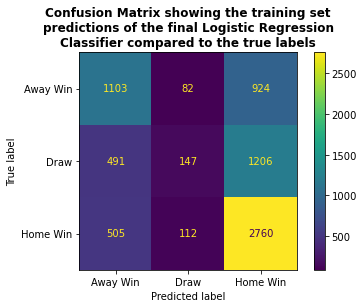

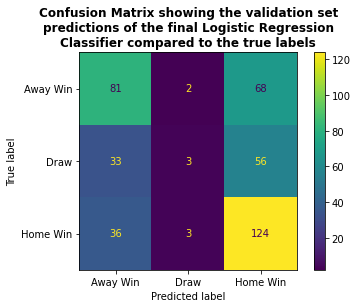

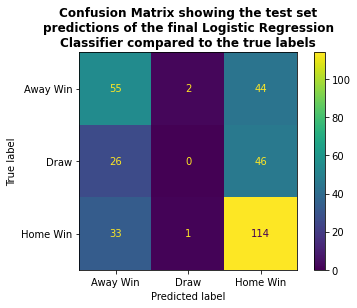

In [214]:
# Plot Confusion Matrix for Final Logistic Regression Model

# Training Set
confusion_matrix = metrics.confusion_matrix(Y_Train, TrainPredictions)

Matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Away Win', 'Draw', 'Home Win'])
# Home win = 2, Draw = 1, Away win = 0 
Matrix.plot()
Matrix.ax_.set_title("Confusion Matrix showing the training set\npredictions of the final Logistic Regression\nClassifier compared to the true labels", fontsize = 12, fontweight ='bold')
plt.show()

# Validation Set
confusion_matrix = metrics.confusion_matrix(Y_Validate, ValidatePredictions)

Matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Away Win', 'Draw', 'Home Win'])
# Home win = 2, Draw = 1, Away win = 0 
Matrix.plot()
Matrix.ax_.set_title("Confusion Matrix showing the validation set\npredictions of the final Logistic Regression\nClassifier compared to the true labels", fontsize = 12, fontweight ='bold')
plt.show()

# Test Set
confusion_matrix = metrics.confusion_matrix(Y_Test, TestPredictions)

Matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Away Win', 'Draw', 'Home Win'])
# Home win = 2, Draw = 1, Away win = 0 
Matrix.plot()
Matrix.ax_.set_title("Confusion Matrix showing the test set\npredictions of the final Logistic Regression\nClassifier compared to the true labels", fontsize = 12, fontweight ='bold')
plt.show()

In [215]:
# Final Predictions on Test Set

# IMPORT TEST SET

NewFeatures = pd.read_csv("epl-test.csv")

# CONVERT CATEGORIAL HOME AND AWAY TEAM FEATURES INTO MULTIPLE BINARY FEATURES

for i in range(0,UniqueHomeTeams.shape[0]):
    Team = UniqueHomeTeams[i]
    NewFeatures[Team+"Home"] = 0
    for j in range(0, NewFeatures.shape[0]): # From a to b-1
        if NewFeatures.iloc[j, NewFeatures.columns.get_loc("HomeTeam")] == Team:
            NewFeatures.iloc[j, NewFeatures.columns.get_loc(Team+"Home")] = 1 

for i in range(0,UniqueAwayTeams.shape[0]):
    Team = UniqueAwayTeams[i]
    NewFeatures[Team+"Away"] = 0
    for j in range(0, NewFeatures.shape[0]): # From a to b-1
        if NewFeatures.iloc[j, NewFeatures.columns.get_loc("AwayTeam")] == Team:
            NewFeatures.iloc[j, NewFeatures.columns.get_loc(Team+"Away")] = 1 

print(NewFeatures.iloc[0:5,0:5])

         Date     HomeTeam        AwayTeam  CharltonHome  ChelseaHome
0  14/01/2023  Aston Villa           Leeds             0            0
1  14/01/2023    Brentford     Bournemouth             0            0
2  14/01/2023     Brighton       Liverpool             0            0
3  14/01/2023      Chelsea  Crystal Palace             0            1
4  14/01/2023      Everton     Southampton             0            0


In [216]:

print(NewFeatures.iloc[0:9,0:5])

         Date       HomeTeam        AwayTeam  CharltonHome  ChelseaHome
0  14/01/2023    Aston Villa           Leeds             0            0
1  14/01/2023      Brentford     Bournemouth             0            0
2  14/01/2023       Brighton       Liverpool             0            0
3  14/01/2023        Chelsea  Crystal Palace             0            1
4  14/01/2023        Everton     Southampton             0            0
5  14/01/2023     Man United        Man City             0            0
6  14/01/2023      Newcastle          Fulham             0            0
7  14/01/2023  Nott'm Forest       Leicester             0            0
8  14/01/2023      Tottenham         Arsenal             0            0


In [217]:
NewFeatures["AT-DT-Km"] = 0 # AWAY TEAM DISTANCE TRAVELLED KILOMETRES
Earthradius = 6371000
for i in range (NewFeatures.shape[0]):
    HomeTeam = NewFeatures.iloc[i, NewFeatures.columns.get_loc("HomeTeam")]
    AwayTeam = NewFeatures.iloc[i, NewFeatures.columns.get_loc("AwayTeam")]
    HomeLatitude = Teams.iloc[Teams.loc[Teams['Team'] == HomeTeam].index[0], Teams.columns.get_loc("Stadium Latitude")] * math.pi / 180
    HomeLongitude = Teams.iloc[Teams.loc[Teams['Team'] == HomeTeam].index[0], Teams.columns.get_loc("Stadium Longitude")] * math.pi / 180
    AwayLatitude = Teams.iloc[Teams.loc[Teams['Team'] == AwayTeam].index[0], Teams.columns.get_loc("Stadium Latitude")] * math.pi / 180
    AwayLongitude = Teams.iloc[Teams.loc[Teams['Team'] == AwayTeam].index[0], Teams.columns.get_loc("Stadium Longitude")] * math.pi / 180
    DistanceTravelled = Earthradius * math.acos( math.sin(HomeLatitude)*math.sin(AwayLatitude) + math.cos(HomeLatitude)*math.cos(AwayLatitude)*math.cos(HomeLongitude-AwayLongitude) ) / 1000
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("AT-DT-Km")] = DistanceTravelled

print(NewFeatures.iloc[0:5,-6:])

   BournemouthAway  HuddersfieldAway  BrightonAway  BrentfordAway  Nott'm ForestAway    AT-DT-Km
0                0                 0             0              0                  0  142.722619
1                1                 0             0              0                  0  136.048946
2                0                 0             0              0                  0  346.759061
3                0                 0             0              0                  0   11.277077
4                0                 0             0              0                  0  301.229322


In [218]:
# mean performance of teams in these 10 matches
#  over all the previous matches of the first dataset.

NewFeatures = pd.concat([NewFeatures, pd.DataFrame(0, index=NewFeatures.index, columns=["FTHG","FTAG",'HTHG','HTAG','HS','AS','HST','AST','HC','AC','HF','AF','HY','AY','HR','AR','HFTR','HHTR','AFTR','AHTR'])], axis=1)

for i in range (NewFeatures.shape[0]):
    HomeTeam = NewFeatures.iloc[i, NewFeatures.columns.get_loc("HomeTeam")] # Take team names
    AwayTeam = NewFeatures.iloc[i, NewFeatures.columns.get_loc("AwayTeam")]
    Homelistindex = Teams.loc[Teams['Team'] == HomeTeam].index[0] # Add home team's previous mean performance to the current football match in the data set
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("FTHG")] = Homelist[Homelistindex]['FTHG'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HTHG")] = Homelist[Homelistindex]['HTHG'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HS")] = Homelist[Homelistindex]['HS'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HST")] = Homelist[Homelistindex]['HST'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HC")] = Homelist[Homelistindex]['HC'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HF")] = Homelist[Homelistindex]['HF'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HY")] = Homelist[Homelistindex]['HY'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HR")] = Homelist[Homelistindex]['HR'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HFTR")] = Homelist[Homelistindex]['FTR'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HHTR")] = Homelist[Homelistindex]['HTR'].mean()

    Awaylistindex = Teams.loc[Teams['Team'] == AwayTeam].index[0]
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("FTAG")] = Awaylist[Awaylistindex]['FTAG'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HTAG")] = Awaylist[Awaylistindex]['HTAG'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("AS")] = Awaylist[Awaylistindex]['AS'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("AST")] = Awaylist[Awaylistindex]['AST'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("AC")] = Awaylist[Awaylistindex]['AC'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("AF")] = Awaylist[Awaylistindex]['AF'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("AY")] = Awaylist[Awaylistindex]['AY'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("AR")] = Awaylist[Awaylistindex]['AR'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("AFTR")] = -Awaylist[Awaylistindex]['FTR'].mean()
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("AHTR")] = -Awaylist[Awaylistindex]['HTR'].mean()


In [219]:
NewFeatures = pd.concat([NewFeatures, pd.DataFrame(0, index=NewFeatures.index, columns=["HSPT_PPM","HSPT_+/-","ASPT_PPM","ASPT_+/-"])], axis=1)

In [220]:
# ADD 2021 SEASON PPM AND +/- STATISTICS TO THESE 10 2022 SEASON MATCHES

Season = 2022 - 1 # Need data from previous season

for i in range (NewFeatures.shape[0]):
    HomeTeam = NewFeatures.iloc[i, NewFeatures.columns.get_loc("HomeTeam")] # Take team names
    AwayTeam = NewFeatures.iloc[i, NewFeatures.columns.get_loc("AwayTeam")]

    Row = ExtraFeatures[(ExtraFeatures['HomeTeam'] == HomeTeam) & (ExtraFeatures['Season'] == Season) ]

    if Row.shape[0] == 0: # If the row is empty the team was not present in the previous season
        Row = ExtraFeatures[ExtraFeatures['Season'] == Season].quantile(0.1,numeric_only=True) # Use that season's 10th percentile instead
        Points = Row['SPT_PPM']
        PlusMinus = Row['SPT_+/-']

    else:
        Points = Row.iloc[0, Row.columns.get_loc('SPT_PPM')]
        PlusMinus = Row.iloc[0, Row.columns.get_loc('SPT_+/-')]

    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HSPT_PPM")] = Points
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("HSPT_+/-")] = PlusMinus
    
    Row = ExtraFeatures[(ExtraFeatures['HomeTeam'] == AwayTeam) & (ExtraFeatures['Season'] == Season ) ]
    # The teams column in the ExtraFeatures dataframe is called HomeTeam but can be applied to both home and away teams in the Features dataframe

    if Row.shape[0] == 0:
        Row = ExtraFeatures[ExtraFeatures['Season'] == Season].quantile(0.1,numeric_only=True) # If the row is empty
        Points = Row['SPT_PPM']
        PlusMinus = Row['SPT_+/-']

    else:
        Points = Row.iloc[0, Row.columns.get_loc('SPT_PPM')]
        PlusMinus = Row.iloc[0, Row.columns.get_loc('SPT_+/-')]

    NewFeatures.iloc[i, NewFeatures.columns.get_loc("ASPT_PPM")] = Points
    NewFeatures.iloc[i, NewFeatures.columns.get_loc("ASPT_+/-")] = PlusMinus

In [221]:
# MAKE SURE THAT THE INFORMATION IN THE NEWFEATURES DATAFRAME IS CORRECT

print(NewFeatures.iloc[3,0:5])
print(NewFeatures.iloc[3,-5:])
Row = ExtraFeatures[(ExtraFeatures['HomeTeam'] == 'Chelsea') & (ExtraFeatures['Season'] == 2021) ]
print(Row)

Date                14/01/2023
HomeTeam               Chelsea
AwayTeam        Crystal Palace
CharltonHome                 0
ChelseaHome                  1
Name: 3, dtype: object
AHTR       -0.123077
HSPT_PPM        1.95
HSPT_+/-        43.0
ASPT_PPM        1.26
ASPT_+/-         4.0
Name: 3, dtype: object
   HomeTeam  Season  SPT_PPM  SPT_+/-  SS_SoT  SS_Gls
25  Chelsea    2021     1.95       43     200      75


In [222]:
# scale data with minmax scaler used previously
removed_columns =  ["Date", "HomeTeam", "AwayTeam"]
selected_columns = NewFeatures.columns[~NewFeatures.columns.isin(removed_columns)]
NewFeatures[selected_columns] = scaler.fit_transform(NewFeatures[selected_columns])
NewFeatures = NewFeatures.reset_index(drop='True')

#NewFeatures.to_csv('NewFeatures.csv') 

# CREATE PREDICTION SET
NewTest = NewFeatures.drop(columns = ["Date", "HomeTeam", "AwayTeam"])


In [223]:
# PREDICT WITH SUPPORT VECTOR CLASSIFIER
Predictions = fSVCm.predict(NewTest)

print(Predictions) # 0 IS AWAY WIN, 2 IS HOME WIN

[2 2 0 2 2 0 2 0 0 2]


In [224]:
# ADD PREDICTIONS TO NEW CSV FILE

PredictionFile = pd.read_csv("epl-test.csv")

PredictionFile["Prediction"] = 0

for i in range(Predictions.size):

    if Predictions[i] == 0:
        Prediction = "Away Win"
    elif Predictions[i] == 1:
        Prediction = "Draw"
    else:
        Prediction = "Home Win"

    PredictionFile.iloc[i, PredictionFile.columns.get_loc("Prediction")] = Prediction

print(PredictionFile)

   
PredictionFile.to_csv('Predictions.csv')  


         Date       HomeTeam        AwayTeam Prediction
0  14/01/2023    Aston Villa           Leeds   Home Win
1  14/01/2023      Brentford     Bournemouth   Home Win
2  14/01/2023       Brighton       Liverpool   Away Win
3  14/01/2023        Chelsea  Crystal Palace   Home Win
4  14/01/2023        Everton     Southampton   Home Win
5  14/01/2023     Man United        Man City   Away Win
6  14/01/2023      Newcastle          Fulham   Home Win
7  14/01/2023  Nott'm Forest       Leicester   Away Win
8  14/01/2023      Tottenham         Arsenal   Away Win
9  14/01/2023         Wolves        West Ham   Home Win
